In [1]:
!pip install pulp
!pip install folium

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pulp
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Initialize seaborn (for plotting)
sns.set()

In [3]:
# Read data
df_distances = pd.read_csv("distances.csv")
df_distances

,origin,destination,distance
0,Scarborough (Malvern / Rouge River),Scarborough (Rouge Hill / Port Union / Highlan...,3.931478
1,Scarborough (Malvern / Rouge River),Scarborough (Guildwood / Morningside / Ellesmere),4.864191
2,Scarborough (Malvern / Rouge River),Scarborough (Woburn),4.778347
3,Scarborough (Malvern / Rouge River),Scarborough (Cedarbrae),6.009861
4,Scarborough (Malvern / Rouge River),Scarborough (Eglinton),7.876162
...,...,...,...
10297,Etobicoke (South Steeles / Silverstone / Humbe...,Etobicoke (Westmount),6.971037
10298,Etobicoke Northwest (Clairville / Humberwood /...,Etobicoke (Westmount),5.185601
10299,Etobicoke (South Steeles / Silverstone / Humbe...,Etobicoke (Kingsview Village / St. Phillips / ...,6.390667
10300,Etobicoke Northwest (Clairville / Humberwood /...,Etobicoke (Kingsview Village / St. Phillips / ...,3.793723


# Part 1

In [4]:
# Read data
df_part1_orderA = pd.read_csv("part1_ordersA.csv")
df_part1_orderA

,restaurant,customer
0,Downtown Toronto (Underground city),Downtown Toronto (Central Bay Street)


In [5]:
# Read data
df_part1_orderB = pd.read_csv("part1_ordersB.csv")
df_part1_orderB

,restaurant,customer
0,Downtown Toronto (Central Bay Street),Downtown Toronto (Underground city)
1,Etobicoke Northwest (Clairville / Humberwood /...,Etobicoke (South Steeles / Silverstone / Humbe...
2,York (Cedarvale),Central Toronto (The Annex / North Midtown / Y...
3,Downtown Toronto (Central Bay Street),Downtown Toronto (Richmond / Adelaide / King)
4,Downtown Toronto (Richmond / Adelaide / King),Downtown Toronto (St. James Town / Cabbagetown)


In [6]:
order = df_part1_orderB

Sets

In [7]:
# origins
origins = list(df_distances['origin'].unique())
numorigins = len(origins)

# destination
destinations = list(df_distances['destination'].unique())
numdestinations = len(destinations)

# restaurant
restaurants = list(order['restaurant'])

# customer
customers = list(order['customer'])

# Origin Point
origin_point = 'Downtown Toronto (Rosedale)'

# location
combined = pd.concat([order['restaurant'], order['customer']])
spots = list(combined.unique())

# step 
if origin_point not in customers:
    spots.append(origin_point)
    steps  = list(range(len(spots)-1))
    
# add a case that there is customer who live in the same place as the driver's start point    
if origin_point in customers:
    steps  = list(range(len(spots)))

Parameters

In [8]:
# Distance between origin and destination (dictionary)
distances = {}
for i in origins:
    for j in destinations:
        if i != j:
            distances[(i,j)] = df_distances.loc[(df_distances['origin'] == i) & (df_distances['destination'] == j)]['distance'].values[0]


Variables

In [9]:
# Variables: if a route is picked
xvar = pulp.LpVariable.dict("x", (spots, spots, steps), cat=pulp.LpBinary)

Model Initialization

In [10]:
# Initialize model and objective sense
RouteModel = pulp.LpProblem(name="RouteModel", sense=pulp.LpMinimize)

Constraints

In [11]:
# Every location visited once
for j in spots:
    if j != origin_point:
        RouteModel += pulp.lpSum([xvar[(i,j,t)] for i in spots for t in steps]) == 1
    else:
        if j in customers:
            RouteModel += pulp.lpSum([xvar[(i,j,t)] for i in spots for t in steps]) == 1

# Conservation of flow
for j in spots:
    for t in steps[:-1]: 
        RouteModel += pulp.lpSum([xvar[(i,j,t)] for i in spots if i != j]) ==  pulp.lpSum([xvar[(j,k,t+1)] for k in spots])
        
# Set Downtown Toronto (Rosedale) as the start point
for i in spots:
    if i == origin_point:
        RouteModel += pulp.lpSum([xvar[(i,j,0)] for j in spots]) == 1
        
    else:
        RouteModel += pulp.lpSum([xvar[(i,j,0)] for j in spots]) == 0
        
# The corresponding restaurant must been visited before the customer
for t in steps:
    for j in customers:
        RouteModel += pulp.lpSum([xvar[(restaurants[customers.index(j)], k ,m)] for k in spots for m in list(range(t+1))])\
        >= pulp.lpSum([xvar[(i,j,t)] for i in spots])
    
# After finishing all deliveris, the driver parks the car in the neighborhood where the last order has been placed
RouteModel += pulp.lpSum([xvar[(i,j,max(steps))] for i in spots for j in customers]) == 1
        


Objective Function

In [12]:
# D_ij * X_ij 
obj = pulp.lpSum(distances[(i,j)] * xvar[(i,j,t)] for i in spots for j in spots if j != i for t in steps)

# add objective to model
RouteModel += obj

Solution Process

In [13]:
# Solve model
RouteModel.solve()
print("Status:", pulp.LpStatus[RouteModel.status])
print("Objective Function",pulp.value(RouteModel.objective))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/lydia/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/2180c37485b549c6a12e3b6ad7fd756b-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/2180c37485b549c6a12e3b6ad7fd756b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 126 COLUMNS
At line 5712 RHS
At line 5834 BOUNDS
At line 6483 ENDATA
Problem MODEL has 121 rows, 648 columns and 3673 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 19.9207 - 0.00 seconds
Cgl0002I 72 variables fixed
Cgl0003I 48 fixed, 0 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0004I processed model has 99 rows, 450 columns (450 integer (450 of which binary)) and 2491 elements
Cbc0038I Initial state - 22 integers unsatisf

In [14]:
route = []
for t in steps:
    for j in spots:
        for i in spots:
            if xvar[(i,j,t)].varValue == 1:
                route.append((i,j,t))

In [15]:
order

,restaurant,customer
0,Downtown Toronto (Central Bay Street),Downtown Toronto (Underground city)
1,Etobicoke Northwest (Clairville / Humberwood /...,Etobicoke (South Steeles / Silverstone / Humbe...
2,York (Cedarvale),Central Toronto (The Annex / North Midtown / Y...
3,Downtown Toronto (Central Bay Street),Downtown Toronto (Richmond / Adelaide / King)
4,Downtown Toronto (Richmond / Adelaide / King),Downtown Toronto (St. James Town / Cabbagetown)


In [16]:
route

[('Downtown Toronto (Rosedale)', 'Downtown Toronto (Central Bay Street)', 0),
 ('Downtown Toronto (Central Bay Street)',
  'Downtown Toronto (Richmond / Adelaide / King)',
  1),
 ('Downtown Toronto (Richmond / Adelaide / King)',
  'Downtown Toronto (Underground city)',
  2),
 ('Downtown Toronto (Underground city)',
  'Downtown Toronto (St. James Town / Cabbagetown)',
  3),
 ('Downtown Toronto (St. James Town / Cabbagetown)', 'York (Cedarvale)', 4),
 ('York (Cedarvale)',
  'Central Toronto (The Annex / North Midtown / Yorkville)',
  5),
 ('Central Toronto (The Annex / North Midtown / Yorkville)',
  'Etobicoke Northwest (Clairville / Humberwood / Woodbine Downs / West Humber / Kipling Heights / Rexdale / Elms / Tandridge / Old Rexdale)',
  6),
 ('Etobicoke Northwest (Clairville / Humberwood / Woodbine Downs / West Humber / Kipling Heights / Rexdale / Elms / Tandridge / Old Rexdale)',
  'Etobicoke (South Steeles / Silverstone / Humbergate / Jamestown / Mount Olive / Beaumond Heights / Thi

In [17]:
# Map the route
import folium
import pandas as pd

# Read the dataset
df_regions = pd.read_csv("regions.csv")

# Function to get latitude and longitude for a location
def get_lat_lng(location_name):
    lat = df_regions[df_regions["name"] == location_name]["latitude"].values[0]
    lng = df_regions[df_regions["name"] == location_name]["longitude"].values[0]
    return lat, lng

# Create a map with the starting point
origin_lat, origin_lng = get_lat_lng("Downtown Toronto (Rosedale)")
toronto_map = folium.Map(location=[origin_lat, origin_lng], zoom_start=12)

# Add markers and labels for each location in the route
for i, j, t in route:
    lat1, lng1 = get_lat_lng(i)
    lat2, lng2 = get_lat_lng(j)
    
    # Add markers
    folium.Marker([lat1, lng1], popup=i).add_to(toronto_map)
    folium.Marker([lat2, lng2], popup=j).add_to(toronto_map)
    
    # Add labels with empty strings
    folium.map.Marker(
        [lat1, lng1],
        icon=folium.DivIcon(icon_size=(150, 36),
                            icon_anchor=(0, 0),
                            html='<div style="font-size: 10pt"></div>',
                            )
    ).add_to(toronto_map)
    
    folium.map.Marker(
        [lat2, lng2],
        icon=folium.DivIcon(icon_size=(150, 36),
                            icon_anchor=(0, 0),
                            html='<div style="font-size: 10pt"></div>',
                            )
    ).add_to(toronto_map)
    
    # Draw lines between the points to represent the route
    folium.PolyLine([(lat1, lng1), (lat2, lng2)], color="blue", weight=2.5, opacity=0.8).add_to(toronto_map)

# Show the map
toronto_map


99
Cbc0038I Pass  35: suminf.    4.60272 (15) obj. 38.3803 iterations 105
Cbc0038I No solution found this major pass
Cbc0038I Before mini branch and bound, 315 integers at bound fixed and 0 continuous
Cbc0038I Full problem 99 rows 450 columns, reduced to 77 rows 126 columns
Cbc0038I Mini branch and bound improved solution from 42.352 to 37.6705 (0.09 seconds)
Cbc0038I Round again with cutoff of 33.1175
Cbc0038I Reduced cost fixing fixed 141 variables on major pass 4
Cbc0038I Pass  35: suminf.    7.00000 (36) obj. 33.1175 iterations 8
Cbc0038I Pass  36: suminf.    7.09716 (34) obj. 33.1175 iterations 46
Cbc0038I Pass  37: suminf.    7.20000 (33) obj. 31.7356 iterations 71
Cbc0038I Pass  38: suminf.    7.42857 (38) obj. 33.1175 iterations 76
Cbc0038I Pass  39: suminf.    7.33333 (22) obj. 33.093 iterations 53
Cbc0038I Pass  40: suminf.    6.20000 (21) obj. 32.1046 iterations 83
Cbc0038I Pass  41: suminf.    3.12409 (25) obj. 33.1175 iterations 55
Cbc0038I Pass  42: suminf.    1.52091 (21

# Part 2

In [18]:
# Read data
df_part2_orderA = pd.read_csv("part2_ordersA.csv", parse_dates=['estimated availability'])
df_part2_orderA

,restaurant,customer,estimated availability
0,Scarborough (Kennedy Park / Ionview / East Bir...,Scarborough (Woburn),2022-04-02 19:27:00
1,Central Toronto (North Toronto West),Etobicoke (Westmount),2022-04-02 20:30:00


In [19]:
# Read data
df_part2_orderB = pd.read_csv("part2_ordersB.csv", parse_dates=['estimated availability'])
df_part2_orderB

,restaurant,customer,estimated availability
0,Etobicoke (Islington Avenue),Downtown Toronto Stn A PO Boxes 25 The Esplana...,2022-04-02 17:17:00
1,North York (Sweeney Park / Wigmore Park),Downtown Toronto (University of Toronto / Harb...,2022-04-02 17:49:00
2,Scarborough (The Golden Mile / Clairlea / Oakr...,Downtown Toronto (Rosedale),2022-04-02 18:17:00
3,Etobicoke (Westmount),Etobicoke (West Deane Park / Princess Gardens ...,2022-04-02 17:53:00


In [20]:
order = df_part2_orderB

In [21]:
# find the earliest datetime value in the "estimated availability" column
earliest_time = order['estimated availability'].min()

In [22]:
# calculate the time difference in minutes
order['reference minutes'] = (order['estimated availability'] - earliest_time).dt.total_seconds() // 60

In [23]:
order

,restaurant,customer,estimated availability,reference minutes
0,Etobicoke (Islington Avenue),Downtown Toronto Stn A PO Boxes 25 The Esplana...,2022-04-02 17:17:00,0.0
1,North York (Sweeney Park / Wigmore Park),Downtown Toronto (University of Toronto / Harb...,2022-04-02 17:49:00,32.0
2,Scarborough (The Golden Mile / Clairlea / Oakr...,Downtown Toronto (Rosedale),2022-04-02 18:17:00,60.0
3,Etobicoke (Westmount),Etobicoke (West Deane Park / Princess Gardens ...,2022-04-02 17:53:00,36.0


Sets

In [24]:
# origins
origins = list(df_distances['origin'].unique())
numorigins = len(origins)

# destination
destinations = list(df_distances['destination'].unique())
numdestinations = len(destinations)

# restaurant
restaurants = list(order['restaurant'])

# customer
customers = list(order['customer'])

# Origin Point
origin_point = 'Downtown Toronto (Rosedale)'

# location
combined = pd.concat([order['restaurant'], order['customer']])
spots = list(combined.unique())

# step 
if origin_point not in customers:
    spots.append(origin_point)
    steps  = list(range(len(spots)-1))
    
# add a case that there is customer who live in the same place as the driver's start point    
if origin_point in customers:
    steps  = list(range(len(spots)))
    
# Waiting time setted in the question
W = 80

Parameters

In [25]:
# Distance between origin and destination (dictionary)
distances = {}
for i in origins:
    for j in destinations:
        if i != j:
            distances[(i,j)] = df_distances.loc[(df_distances['origin'] == i) & (df_distances['destination'] == j)]['distance'].values[0]


# Time for travel(Based on distance) between origin and destination (dictionary)
distances_time = {}
for i in origins:
    for j in destinations:
        if i != j:
            distances_time[(i,j)] = df_distances.loc[(df_distances['origin'] == i) & (df_distances['destination'] == j)]['distance'].values[0]/40*60


Variables

In [26]:
# Variable indicate if a route is picked
xvar = pulp.LpVariable.dict("x", (spots, spots, steps), cat=pulp.LpBinary)

# Variable indicate the total time used in minutes
Dvar = pulp.LpVariable.dict("D", steps, lowBound=0.0, cat=pulp.LpContinuous)

# Variable indicate the average wait time for customers used in minutes at step t
Wvar = pulp.LpVariable.dict("W", customers, lowBound=0.0, cat=pulp.LpContinuous)

Model Initialization

In [27]:
# Initialize model and objective sense
RouteModel = pulp.LpProblem(name="RouteModel", sense=pulp.LpMinimize)

Constraints

In [28]:
# Every location visited once
for j in spots:
    if j != origin_point:
        RouteModel += pulp.lpSum([xvar[(i,j,t)] for i in spots for t in steps]) == 1
    else:
        if j in customers:
            RouteModel += pulp.lpSum([xvar[(i,j,t)] for i in spots for t in steps]) == 1

# Conservation of flow
for j in spots:
    for t in steps[:-1]: 
        RouteModel += pulp.lpSum([xvar[(i,j,t)] for i in spots if i != j]) ==  pulp.lpSum([xvar[(j,k,t+1)] for k in spots])
        
# Set Downtown Toronto (Rosedale) as the start point
for i in spots:
    if i == origin_point:
        RouteModel += pulp.lpSum([xvar[(i,j,0)] for j in spots]) == 1
        
    else:
        RouteModel += pulp.lpSum([xvar[(i,j,0)] for j in spots]) == 0
        
# The corresponding restaurant must been visited before the customer
for t in steps:
    for j in customers:
        RouteModel += pulp.lpSum([xvar[(restaurants[customers.index(j)], k, m)] for k in spots for m in list(range(t+1))])\
        >= pulp.lpSum([xvar[(i,j,t)] for i in spots])
    
# After finishing all deliveris, the driver parks the car in the neighborhood where the last order has been placed
RouteModel += pulp.lpSum([xvar[(i,j,max(steps))] for i in spots for j in customers]) == 1
    
# D_t for time windows                 
for t in steps:
    if t == 0:
        RouteModel += Dvar[0] >= pulp.lpSum(xvar[(origin_point,j,t)] * order.loc[order['restaurant'] == j]['reference minutes'].values[0] for j in restaurants) 
    else:
        RouteModel += Dvar[t] >= Dvar[t-1] + pulp.lpSum(distances_time[(i,j)] * xvar[(i,j,t)] for i in spots for j in spots if i != j) + \
            5 * pulp.lpSum(xvar[(i,j,t)] for i in spots for j in customers)
    for j in restaurants:
        RouteModel += Dvar[t] >= pulp.lpSum(xvar[(i,j,t)] * order.loc[order['restaurant'] == j]['reference minutes'].values[0] for i in spots if i != j)

# W_t for wait time   
for j in customers:
    for t in steps:
        RouteModel += Wvar[j] >= Dvar[t] - 5 - order.loc[order['customer'] == j]['reference minutes'].values[0] - 10000 * (1 - pulp.lpSum(xvar[(i, j, t)] for i in spots if i != j))
        RouteModel += Wvar[j] <= Dvar[t] - 5 - order.loc[order['customer'] == j]['reference minutes'].values[0] + 10000 * (1 - pulp.lpSum(xvar[(i, j, t)] for i in spots if i != j))
        
RouteModel += pulp.lpSum(Wvar[j] for j in customers) / len(customers) <= W


Objective Function

In [29]:
# D_ij * X_ij 
obj = pulp.lpSum(distances[(i,j)] * xvar[(i,j,t)] for i in spots for j in spots if j != i for t in steps)

# add objective to model
RouteModel += obj

Solution Process

In [30]:
# Solve model
RouteModel.solve()
print("Status:", pulp.LpStatus[RouteModel.status])
print("Objective Function",pulp.value(RouteModel.objective))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/lydia/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/d0a2b5f0d26e4ccab7152b7c30cde0b4-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/d0a2b5f0d26e4ccab7152b7c30cde0b4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 215 COLUMNS
At line 5730 RHS
At line 5941 BOUNDS
At line 6454 ENDATA
Problem MODEL has 210 rows, 524 columns and 4010 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 30.2892 - 0.00 seconds
Cgl0002I 56 variables fixed
Cgl0003I 52 fixed, 0 tightened bounds, 30 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 28 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 30 strengthened rows, 0 substituti

In [31]:
order

,restaurant,customer,estimated availability,reference minutes
0,Etobicoke (Islington Avenue),Downtown Toronto Stn A PO Boxes 25 The Esplana...,2022-04-02 17:17:00,0.0
1,North York (Sweeney Park / Wigmore Park),Downtown Toronto (University of Toronto / Harb...,2022-04-02 17:49:00,32.0
2,Scarborough (The Golden Mile / Clairlea / Oakr...,Downtown Toronto (Rosedale),2022-04-02 18:17:00,60.0
3,Etobicoke (Westmount),Etobicoke (West Deane Park / Princess Gardens ...,2022-04-02 17:53:00,36.0


.9461 iterations 21
Cbc0038I Pass  20: suminf.    0.00000 (0) obj. 51.7408 iterations 83
Cbc0038I Solution found of 51.7408
Cbc0038I Relaxing continuous gives 51.7408
Cbc0038I Before mini branch and bound, 191 integers at bound fixed and 0 continuous
Cbc0038I Full problem 179 rows 379 columns, reduced to 174 rows 186 columns - 3 fixed gives 64, 22 - ok now
Cbc0038I Full problem 179 rows 379 columns, reduced to 0 rows 0 columns
Cbc0038I Mini branch and bound did not improve solution (0.18 seconds)
Cbc0038I Round again with cutoff of 49.9931
Cbc0038I Reduced cost fixing fixed 42 variables on major pass 2
Cbc0038I Pass  21: suminf.    6.60740 (39) obj. 49.9931 iterations 171
Cbc0038I Pass  22: suminf.    5.35210 (39) obj. 49.9931 iterations 60
Cbc0038I Pass  23: suminf.    4.95605 (36) obj. 49.9931 iterations 14
Cbc0038I Pass  24: suminf.    7.00000 (21) obj. 49.6618 iterations 60
Cbc0038I Pass  25: suminf.    5.64318 (40) obj. 49.9931 iterations 60
Cbc0038I Pass  26: suminf.    7.16537 (

In [32]:
route = []
n = 0
total_wait = 0
for t in steps:
    for j in spots:
        for i in spots:
            d = pulp.value(Dvar[t])
            if xvar[(i,j,t)].varValue == 1:
                if j in customers:
                    w = pulp.value(Wvar[j])
                else: w = 0
                total_wait +=w
                route.append((i, j, t, d, w))
print(route)
print(total_wait/len(customers))


[('Downtown Toronto (Rosedale)', 'North York (Sweeney Park / Wigmore Park)', 0, 32.0, 0), ('North York (Sweeney Park / Wigmore Park)', 'Scarborough (The Golden Mile / Clairlea / Oakridge / Birchmount Park East)', 1, 60.0, 0), ('Scarborough (The Golden Mile / Clairlea / Oakridge / Birchmount Park East)', 'Downtown Toronto (Rosedale)', 2, 76.773828, 11.773828), ('Downtown Toronto (Rosedale)', 'Etobicoke (Westmount)', 3, 96.094155, 0), ('Etobicoke (Westmount)', 'Etobicoke (Islington Avenue)', 4, 100.90658, 0), ('Etobicoke (Islington Avenue)', 'Etobicoke (West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale)', 5, 109.76646, 68.766461), ('Etobicoke (West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale)', 'Downtown Toronto (University of Toronto / Harbord)', 6, 133.34485, 96.344852), ('Downtown Toronto (University of Toronto / Harbord)', 'Downtown Toronto Stn A PO Boxes 25 The Esplanade (Enclave of M5E)', 7, 142.35495, 137.35495)]
78.56002275


In [33]:
# Map the route
import folium
import pandas as pd

# Read the dataset
df_regions = pd.read_csv("regions.csv")

# Function to get latitude and longitude for a location
def get_lat_lng(location_name):
    lat = df_regions[df_regions["name"] == location_name]["latitude"].values[0]
    lng = df_regions[df_regions["name"] == location_name]["longitude"].values[0]
    return lat, lng

# Create a map with the starting point
origin_lat, origin_lng = get_lat_lng("Downtown Toronto (Rosedale)")
toronto_map = folium.Map(location=[origin_lat, origin_lng], zoom_start=12)

# Add markers and labels for each location in the route
for i, j, t, d, w in route:
    lat1, lng1 = get_lat_lng(i)
    lat2, lng2 = get_lat_lng(j)
    
    # Add markers
    folium.Marker([lat1, lng1], popup=i).add_to(toronto_map)
    folium.Marker([lat2, lng2], popup=j).add_to(toronto_map)
    
    # Add empty labels
    folium.map.Marker(
        [lat1, lng1],
        icon=folium.DivIcon(icon_size=(150, 36),
                            icon_anchor=(0, 0),
                            html='<div style="font-size: 10pt"></div>',
                            )
    ).add_to(toronto_map)
    
    folium.map.Marker(
        [lat2, lng2],
        icon=folium.DivIcon(icon_size=(150, 36),
                            icon_anchor=(0, 0),
                            html='<div style="font-size: 10pt"></div>',
                            )
    ).add_to(toronto_map)
    
    # Draw lines between the points to represent the route
    folium.PolyLine([(lat1, lng1), (lat2, lng2)], color="blue", weight=2.5, opacity=0.8).add_to(toronto_map)

# Show the map
toronto_map


#Sensitivity

In [34]:
#model 
def model_eval(w):
    # origins
    origins = list(df_distances['origin'].unique())
    numorigins = len(origins)

    # destination
    destinations = list(df_distances['destination'].unique())
    numdestinations = len(destinations)

    # restaurant
    restaurants = list(order['restaurant'])

    # customer
    customers = list(order['customer'])

    # Origin Point
    origin_point = 'Downtown Toronto (Rosedale)'

    # location
    combined = pd.concat([order['restaurant'], order['customer']])
    spots = list(combined.unique())

    # step 
    if origin_point not in customers:
        spots.append(origin_point)
        steps  = list(range(len(spots)-1))

    # add a case that there is customer who live in the same place as the driver's start point    
    if origin_point in customers:
        steps  = list(range(len(spots)))
    
    # Distance between origin and destination (dictionary)
    distances = {}
    for i in origins:
        for j in destinations:
            if i != j:
                distances[(i,j)] = df_distances.loc[(df_distances['origin'] == i) & (df_distances['destination'] == j)]['distance'].values[0]


    # Time for travel(Based on distance) between origin and destination (dictionary)
    distances_time = {}
    for i in origins:
        for j in destinations:
            if i != j:
                distances_time[(i,j)] = df_distances.loc[(df_distances['origin'] == i) & (df_distances['destination'] == j)]['distance'].values[0]/40*60
    
    # Variable indicate if a route is picked
    xvar = pulp.LpVariable.dict("x", (spots, spots, steps), cat=pulp.LpBinary)

    # Variable indicate the total time used in minutes
    Dvar = pulp.LpVariable.dict("D", steps, lowBound=0.0, cat=pulp.LpContinuous)

    # Variable indicate the average wait time for customers used in minutes at step t
    Wvar = pulp.LpVariable.dict("W", customers, lowBound=0.0, cat=pulp.LpContinuous)
    
    # Initialize model and objective sense
    RouteModel = pulp.LpProblem(name="RouteModel", sense=pulp.LpMinimize)
    
    # Every location visited once
    for j in spots:
        if j != origin_point:
            RouteModel += pulp.lpSum([xvar[(i,j,t)] for i in spots for t in steps]) == 1
        else:
            if j in customers:
                RouteModel += pulp.lpSum([xvar[(i,j,t)] for i in spots for t in steps]) == 1

    # Conservation of flow
    for j in spots:
        for t in steps[:-1]: 
            RouteModel += pulp.lpSum([xvar[(i,j,t)] for i in spots if i != j]) ==  pulp.lpSum([xvar[(j,k,t+1)] for k in spots])

    # Set Downtown Toronto (Rosedale) as the start point
    for i in spots:
        if i == origin_point:
            RouteModel += pulp.lpSum([xvar[(i,j,0)] for j in spots]) == 1

        else:
            RouteModel += pulp.lpSum([xvar[(i,j,0)] for j in spots]) == 0

    # The corresponding restaurant must been visited before the customer
    for t in steps:
        for j in customers:
            RouteModel += pulp.lpSum([xvar[(k,restaurants[customers.index(j)],m)] for k in spots for m in list(range(t+1))])\
            >= pulp.lpSum([xvar[(i,j,t)] for i in spots])

    # After finishing all deliveris, the driver parks the car in the neighborhood where the last order has been placed
    RouteModel += pulp.lpSum([xvar[(i,j,max(steps))] for i in spots for j in customers]) == 1

    # D_t for time windows                 
    for t in steps:
        if t == 0:
            RouteModel += Dvar[0] >= pulp.lpSum(xvar[(origin_point,j,t)] * order.loc[order['restaurant'] == j]['reference minutes'].values[0] for j in restaurants) 
        else:
            RouteModel += Dvar[t] >= Dvar[t-1] + pulp.lpSum(distances_time[(i,j)] * xvar[(i,j,t)] for i in spots for j in spots if i != j) + \
                5 * pulp.lpSum(xvar[(i,j,t)] for i in spots for j in customers)
        for j in restaurants:
            RouteModel += Dvar[t] >= pulp.lpSum(xvar[(i,j,t)] * order.loc[order['restaurant'] == j]['reference minutes'].values[0] for i in spots if i != j)

    # W_t for wait time   
    for j in customers:
        for t in steps:
            RouteModel += Wvar[j] >= Dvar[t] - 5 - order.loc[order['customer'] == j]['reference minutes'].values[0] - 10000 * (1 - pulp.lpSum(xvar[(i, j, t)] for i in spots if i != j))
            RouteModel += Wvar[j] <= Dvar[t] - 5 - order.loc[order['customer'] == j]['reference minutes'].values[0] + 10000 * (1 - pulp.lpSum(xvar[(i, j, t)] for i in spots if i != j))

    RouteModel += pulp.lpSum(Wvar[j] for j in customers) / len(customers) <= w
    
    # D_ij * X_ij 
    obj = pulp.lpSum(distances[(i,j)] * xvar[(i,j,t)] for i in spots for j in spots if j != i for t in steps)

    # add objective to model
    RouteModel += obj
    # Solve model
    RouteModel.solve()
    total_wait = 0
    max_wait = 0 
    for t in steps:
        for j in spots:
            for i in spots:
                d = pulp.value(Dvar[t])
                if xvar[(i,j,t)].varValue == 1:
                    if j in customers:
                        w = pulp.value(Wvar[j])
                    else: w = 0
                    total_wait +=w
                    max_wait =max(w,max_wait)
    return pulp.LpStatus[RouteModel.status], pulp.value(RouteModel.objective),total_wait/len(customers),max_wait

In [35]:
w_list = []
distance = []
avg_wait_time = []
max_wait = []
for i in range(30,100,3):
    w_list.append(i)
    stat,value,wait,max_wait_time = model_eval(i)
    if stat == 'Infeasible':
        distance.append(0)
        avg_wait_time.append(0)
        max_wait.append(0)
    else:
        distance.append(value)
        avg_wait_time.append(wait)
        max_wait.append(max_wait_time)
    print(i)
    

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/lydia/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/9dc22337a6d04561b84a1b46beb1afc2-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/9dc22337a6d04561b84a1b46beb1afc2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 215 COLUMNS
At line 5762 RHS
At line 5973 BOUNDS
At line 6486 ENDATA
Problem MODEL has 210 rows, 524 columns and 4074 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 28.0099 - 0.00 seconds
Cgl0002I 56 variables fixed
Cgl0003I 75 fixed, 0 tightened bounds, 61 strengthened rows, 0 substitutions
Cgl0003I 29 fixed, 0 tightened bounds, 26 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 25 strengthened rows, 0 substitut

Text(0.5, 1.0, 'w value VS distance')

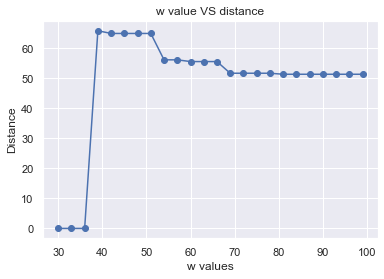

In [36]:
import matplotlib.pyplot as plt
plt.plot(w_list, distance, "-")
plt.scatter(w_list, distance)
plt.xlabel('w values')
plt.ylabel('Distance')
plt.title('w value VS distance')

Text(0.5, 1.0, 'w value VS average wait time')

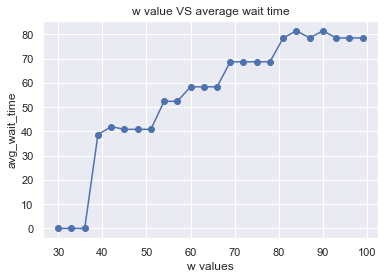

In [37]:
plt.plot(w_list, avg_wait_time, "-")
plt.scatter(w_list, avg_wait_time)
plt.xlabel('w values')
plt.ylabel('avg_wait_time')
plt.title('w value VS average wait time')

Text(0.5, 1.0, 'w value VS max wait time')

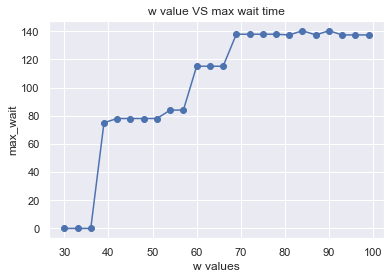

In [38]:
plt.plot(w_list, max_wait, "-")
plt.scatter(w_list, max_wait)
plt.xlabel('w values')
plt.ylabel('max_wait')
plt.title('w value VS max wait time')

Change time evaluation metric to the max wait time

In [39]:
#model with different evaluation
#change time evaluation   
def model_eval_max(w):
    # origins
    origins = list(df_distances['origin'].unique())
    numorigins = len(origins)

    # destination
    destinations = list(df_distances['destination'].unique())
    numdestinations = len(destinations)

    # restaurant
    restaurants = list(order['restaurant'])

    # customer
    customers = list(order['customer'])

    # Origin Point
    origin_point = 'Downtown Toronto (Rosedale)'

    # location
    combined = pd.concat([order['restaurant'], order['customer']])
    spots = list(combined.unique())

    # step 
    if origin_point not in customers:
        spots.append(origin_point)
        steps  = list(range(len(spots)-1))

    # add a case that there is customer who live in the same place as the driver's start point    
    if origin_point in customers:
        steps  = list(range(len(spots)))
    
    # Distance between origin and destination (dictionary)
    distances = {}
    for i in origins:
        for j in destinations:
            if i != j:
                distances[(i,j)] = df_distances.loc[(df_distances['origin'] == i) & (df_distances['destination'] == j)]['distance'].values[0]


    # Time for travel(Based on distance) between origin and destination (dictionary)
    distances_time = {}
    for i in origins:
        for j in destinations:
            if i != j:
                distances_time[(i,j)] = df_distances.loc[(df_distances['origin'] == i) & (df_distances['destination'] == j)]['distance'].values[0]/40*60
    
    # Variable indicate if a route is picked
    xvar = pulp.LpVariable.dict("x", (spots, spots, steps), cat=pulp.LpBinary)

    # Variable indicate the total time used in minutes
    Dvar = pulp.LpVariable.dict("D", steps, lowBound=0.0, cat=pulp.LpContinuous)

    # Variable indicate the average wait time for customers used in minutes at step t
    Wvar = pulp.LpVariable.dict("W", customers, lowBound=0.0, cat=pulp.LpContinuous)
    
    # Initialize model and objective sense
    RouteModel = pulp.LpProblem(name="RouteModel", sense=pulp.LpMinimize)
    
    # Every location visited once
    for j in spots:
        if j != origin_point:
            RouteModel += pulp.lpSum([xvar[(i,j,t)] for i in spots for t in steps]) == 1
        else:
            if j in customers:
                RouteModel += pulp.lpSum([xvar[(i,j,t)] for i in spots for t in steps]) == 1

    # Conservation of flow
    for j in spots:
        for t in steps[:-1]: 
            RouteModel += pulp.lpSum([xvar[(i,j,t)] for i in spots if i != j]) ==  pulp.lpSum([xvar[(j,k,t+1)] for k in spots])

    # Set Downtown Toronto (Rosedale) as the start point
    for i in spots:
        if i == origin_point:
            RouteModel += pulp.lpSum([xvar[(i,j,0)] for j in spots]) == 1

        else:
            RouteModel += pulp.lpSum([xvar[(i,j,0)] for j in spots]) == 0

    # The corresponding restaurant must been visited before the customer
    for t in steps:
        for j in customers:
            RouteModel += pulp.lpSum([xvar[(k,restaurants[customers.index(j)],m)] for k in spots for m in list(range(t+1))])\
            >= pulp.lpSum([xvar[(i,j,t)] for i in spots])

    # After finishing all deliveris, the driver parks the car in the neighborhood where the last order has been placed
    RouteModel += pulp.lpSum([xvar[(i,j,max(steps))] for i in spots for j in customers]) == 1

    # D_t for time windows                 
    for t in steps:
        if t == 0:
            RouteModel += Dvar[0] >= pulp.lpSum(xvar[(origin_point,j,t)] * order.loc[order['restaurant'] == j]['reference minutes'].values[0] for j in restaurants) 
        else:
            RouteModel += Dvar[t] >= Dvar[t-1] + pulp.lpSum(distances_time[(i,j)] * xvar[(i,j,t)] for i in spots for j in spots if i != j) + \
                5 * pulp.lpSum(xvar[(i,j,t)] for i in spots for j in customers)
        for j in restaurants:
            RouteModel += Dvar[t] >= pulp.lpSum(xvar[(i,j,t)] * order.loc[order['restaurant'] == j]['reference minutes'].values[0] for i in spots if i != j)

    # W_t for wait time   
    for j in customers:
        for t in steps:
            RouteModel += Wvar[j] >= Dvar[t] - 5 - order.loc[order['customer'] == j]['reference minutes'].values[0] - 10000 * (1 - pulp.lpSum(xvar[(i, j, t)] for i in spots if i != j))
            RouteModel += Wvar[j] <= Dvar[t] - 5 - order.loc[order['customer'] == j]['reference minutes'].values[0] + 10000 * (1 - pulp.lpSum(xvar[(i, j, t)] for i in spots if i != j))
    
    for j in customers:
        
        RouteModel += Wvar[j] <= w
    
    # D_ij * X_ij 
    obj = pulp.lpSum(distances[(i,j)] * xvar[(i,j,t)] for i in spots for j in spots if j != i for t in steps)

    # add objective to model
    RouteModel += obj
    # Solve model
    RouteModel.solve()
    max_wait = 0
    total_wait = 0
    for t in steps:
        for j in spots:
            for i in spots:
                d = pulp.value(Dvar[t])
                if xvar[(i,j,t)].varValue == 1:
                    if j in customers:
                        w = pulp.value(Wvar[j])
                    else: w = 0
                    max_wait = max(max_wait,w)
                    total_wait += w
    return pulp.LpStatus[RouteModel.status], pulp.value(RouteModel.objective),total_wait/len(customers),max_wait

In [40]:
w_list = []
distance = []
avg_wait_time = []
max_wait = []
for i in range(60,130,5):
    w_list.append(i)
    stat,value,wait,max_wait_time = model_eval_max(i)
    if stat == 'Infeasible':
        distance.append(0)
        avg_wait_time.append(0)
        max_wait.append(0)
    else:
        distance.append(value)
        avg_wait_time.append(wait)
        max_wait.append(max_wait_time)
    print(i)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/lydia/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/01cbeab00a1a46998c2bcba3bc15b09e-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/01cbeab00a1a46998c2bcba3bc15b09e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 218 COLUMNS
At line 5765 RHS
At line 5979 BOUNDS
At line 6492 ENDATA
Problem MODEL has 213 rows, 524 columns and 4074 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 28.0099 - 0.00 seconds
Cgl0002I 56 variables fixed
Cgl0003I 75 fixed, 0 tightened bounds, 74 strengthened rows, 0 substitutions
Cgl0003I 29 fixed, 0 tightened bounds, 41 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 35 strengthened rows, 0 substitut

Text(0.5, 1.0, 'Value pairs line plot with a highlighted point')

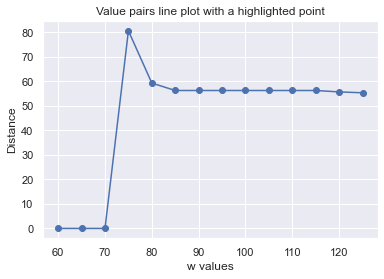

In [41]:
import matplotlib.pyplot as plt
plt.plot(w_list, distance, "-")
plt.scatter(w_list, distance)
plt.xlabel('w values')
plt.ylabel('Distance')
plt.title('Value pairs line plot with a highlighted point')

Text(0.5, 1.0, 'w value VS average wait time')

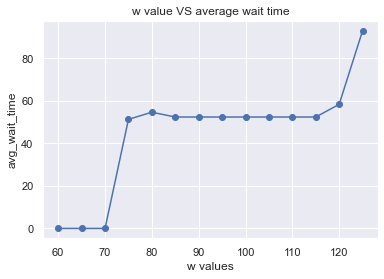

In [42]:
plt.plot(w_list, avg_wait_time, "-")
plt.scatter(w_list, avg_wait_time)
plt.xlabel('w values')
plt.ylabel('avg_wait_time')
plt.title('w value VS average wait time')

Text(0.5, 1.0, 'w value VS max wait time')

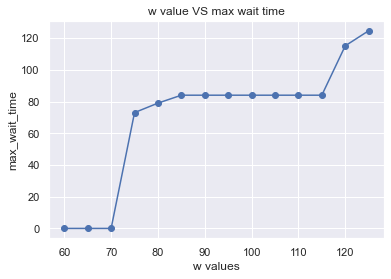

In [43]:
plt.plot(w_list,max_wait, "-")
plt.scatter(w_list,max_wait)
plt.xlabel('w values')
plt.ylabel('max_wait_time')
plt.title('w value VS max wait time')

# Part 3

In [44]:
# Read data
df_drivers = pd.read_csv("part3_drivers.csv")
df_drivers

,start region,velocity
0,Downtown Toronto (Richmond / Adelaide / King),40
1,Downtown Toronto (St. James Park),35
2,Downtown Toronto (Church and Wellesley),32


In [45]:
# Read data
df_part3 = pd.read_csv("part3_small.csv", parse_dates=['estimated availability'])
df_part3

,restaurant,customer,estimated availability
0,Downtown Toronto (Central Bay Street),North York (Armour Heights / Wilson Heights / ...,2022-04-02 17:17:00
1,Downtown Toronto (Christie),West Toronto (Brockton / Parkdale Village / Ex...,2022-04-02 17:49:00
2,Downtown Toronto (Ryerson),York (Fairbank / Oakwood),2022-04-02 18:17:00
3,Downtown Toronto (St. James Park),East Toronto (The Beaches),2022-04-02 17:53:00
4,Downtown Toronto (Kensington Market / Chinatow...,Downtown Toronto (Central Bay Street),2022-04-02 17:24:00


In [46]:
order = df_part3

In [47]:
# find the earliest datetime value in the "estimated availability" column
earliest_time = order['estimated availability'].min()

In [48]:
# calculate the time difference in minutes
order['reference minutes'] = (order['estimated availability'] - earliest_time).dt.total_seconds() // 60

In [49]:
order

,restaurant,customer,estimated availability,reference minutes
0,Downtown Toronto (Central Bay Street),North York (Armour Heights / Wilson Heights / ...,2022-04-02 17:17:00,0.0
1,Downtown Toronto (Christie),West Toronto (Brockton / Parkdale Village / Ex...,2022-04-02 17:49:00,32.0
2,Downtown Toronto (Ryerson),York (Fairbank / Oakwood),2022-04-02 18:17:00,60.0
3,Downtown Toronto (St. James Park),East Toronto (The Beaches),2022-04-02 17:53:00,36.0
4,Downtown Toronto (Kensington Market / Chinatow...,Downtown Toronto (Central Bay Street),2022-04-02 17:24:00,7.0


set

In [50]:
# origins
origins = list(df_distances['origin'].unique())
numorigins = len(origins)

# destination
destinations = list(df_distances['destination'].unique())
numdestinations = len(destinations)

# restaurant
restaurants = list(order['restaurant'])

# customer
customers = list(order['customer'])

# start_region for drivers
starts = list(df_drivers['start region'])

# locations with the start point of available drivers
combined = pd.concat([order['restaurant'], order['customer'],df_drivers['start region']])
start_spots = list(combined.unique())

# location
combined = pd.concat([order['restaurant'], order['customer']])
spots = list(combined.unique())

# step 
steps  = list(range(len(spots)-1))
    
# Waiting time setted in the question
W = 60

#drivers
start_region = dict(enumerate(df_drivers['start region']))
velocity = dict(enumerate(df_drivers['velocity']))
drivers = list(range(len(start_region)))

In [51]:
# Distance between origin and destination (dictionary)
distances = {}
for i in origins:
    for j in destinations:
        if i != j:
            distances[(i,j)] = df_distances.loc[(df_distances['origin'] == i) & (df_distances['destination'] == j)]['distance'].values[0]

variables

In [52]:
# Variable indicate if a route is picked
xvar = pulp.LpVariable.dict("x", (start_spots, spots, steps, drivers), cat=pulp.LpBinary)

# Variable indicate the total time used in minutes
Dvar = pulp.LpVariable.dict("D", (steps,drivers), lowBound=0.0, cat=pulp.LpContinuous)

# Variable indicate the average wait time for customers used in minutes at step t
Wvar = pulp.LpVariable.dict("W", customers, lowBound=0.0, cat=pulp.LpContinuous)

model initialization 

In [53]:
# Initialize model and objective sense
RouteModel = pulp.LpProblem(name="RouteModel", sense=pulp.LpMinimize)

Constraints

In [54]:
# Visit every restaurant and customer once（if j not in start, visit once, otherwise, no visit is allowed）
for j in spots:
    if j not in starts:
        RouteModel += pulp.lpSum([xvar[(i,j,t,s)] for i in start_spots if i != j for t in steps for s in drivers]) == 1
    else:
        RouteModel += pulp.lpSum([xvar[(i,j,t,s)] for i in start_spots if i != j for t in steps for s in drivers]) <= 1

# For every driver, at step 0, if the start point of route is in start_region, only one route or no route is allowed
# if the start point of route is not the start_region of the driver at step 0, no route allowed
for s in drivers:
    RouteModel += pulp.lpSum([xvar[(starts[s],j,0,s)] for j in spots if j not in starts]) == 1 # change later
    RouteModel += pulp.lpSum([xvar[(i,j,0,s)] for i in spots if i != starts[s] for j in spots]) == 0
    # If statement for case that if start region not happen to be restaurant or customer, then no leaving
    # form the start point is allowed except step = 0
    if starts[s] not in spots:
        RouteModel += pulp.lpSum([xvar[(starts[s],j,t,s)] for j in spots for t in steps if t != 0]) == 0 
 
# For each driver in each step, they can choose to move one step or not move
for s in drivers:
    for t in steps:
        RouteModel += pulp.lpSum([xvar[(i,j,t,s)] for i in start_spots for j in spots]) <= 1

# add step constraint if necessary
for s in drivers:
    for t in steps[:-1]:
        RouteModel += pulp.lpSum([xvar[i,j,t,s] for i in start_spots for j in spots]) >= \
        pulp.lpSum([xvar[i,j,t+1,s] for i in start_spots for j in spots])

# The corresponding restaurant must been visited before the customer
for t in steps[:-1]:
    for j in customers:
        for s in drivers:
            RouteModel += pulp.lpSum([xvar[(restaurants[customers.index(j)],i,m,s)] for i in spots for m in list(range(t+1))])\
            >= pulp.lpSum([xvar[(i,j,t,s)] for i in start_spots if i != j])        
        
# Conservation of flow
# for restaurant, the outflow = inflow
for j in restaurants:
    for t in steps[:-1]: 
        for s in drivers:
            RouteModel += pulp.lpSum([xvar[(i,j,t,s)] for i in start_spots if i != j]) ==  pulp.lpSum([xvar[(j,k,t+1,s)] for k in spots])

# for customers, we allow inflow >= outflow so that driver can stop at customers 
for j in customers:
    for t in steps[:-1]: 
        for s in drivers:
            RouteModel += pulp.lpSum([xvar[(i,j,t,s)] for i in start_spots if i != j]) >=  pulp.lpSum([xvar[(j,k,t+1,s)] for k in spots])    
    
# cannot go from i to i
for t in steps:
    for s in drivers:
        RouteModel += pulp.lpSum([xvar[(i,j,t,s)] for i in start_spots for j in spots if i == j]) == 0
        
    
# D_t for time windows       

for t in steps:
    for s in drivers:
        if t == 0:
            RouteModel += Dvar[0,s] >= pulp.lpSum(xvar[(start_region[s],j,t,s)] * order.loc[order['restaurant'] == j]['reference minutes'].values[0] for j in restaurants) 
        else:
            RouteModel += Dvar[t,s] >= Dvar[t-1,s] + pulp.lpSum(distances[(i,j)]/(velocity[s]/60) * xvar[(i,j,t,s)] for i in start_spots for j in spots if i != j) + \
                5 * pulp.lpSum(xvar[(i,j,t,s)] for i in start_spots for j in customers)
        for j in restaurants:
            RouteModel += Dvar[t,s] >= pulp.lpSum(xvar[(i,j,t,s)] * order.loc[order['restaurant'] == j]['reference minutes'].values[0] for i in start_spots if i != j)

#W_t for wait time   

for j in customers:
    for t in steps:
        for s in drivers:
            RouteModel += Wvar[j] >= Dvar[t,s] - 5 - order.loc[order['customer'] == j]['reference minutes'].values[0] - 10000 * (1 - pulp.lpSum(xvar[(i, j, t, s)] for i in start_spots if i != j))
            RouteModel += Wvar[j] <= Dvar[t,s] - 5 - order.loc[order['customer'] == j]['reference minutes'].values[0] + 10000 * (1 - pulp.lpSum(xvar[(i, j, t, s)] for i in start_spots if i != j))
        
RouteModel += pulp.lpSum(Wvar[j] for j in customers) / len(customers) <= W

Objective

In [55]:
# D_ij * X_ij 
obj = pulp.lpSum(distances[(i,j)] * xvar[(i,j,t,s)] for i in start_spots for j in spots if j != i for t in steps for d in drivers)

# add objective to model
RouteModel += obj

solution

In [56]:
# Solve model
RouteModel.solve(pulp.PULP_CBC_CMD(timeLimit=120))
print('Time elapsed:', RouteModel.solutionTime)
print("Status:", pulp.LpStatus[RouteModel.status])
print("Objective Function",pulp.value(RouteModel.objective))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/lydia/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/dc5dae8fc76c4fe081be7fe6cb6d34c5-pulp.mps sec 120 timeMode elapsed branch printingOptions all solution /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/dc5dae8fc76c4fe081be7fe6cb6d34c5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 791 COLUMNS
At line 30290 RHS
At line 31077 BOUNDS
At line 33454 ENDATA
Problem MODEL has 786 rows, 2405 columns and 23921 elements
Coin0008I MODEL read with 0 errors
seconds was changed from 1e+100 to 120
Option for timeMode changed from cpu to elapsed
Continuous objective value is 16.7823 - 0.02 seconds
Cgl0002I 550 variables fixed
Cgl0003I 122 fixed, 0 tightened bounds, 194 strengthened rows, 0 substitutions
Cgl0003I 10 fixed, 0 tightened bounds, 158 strengthened rows, 0 substitutions
Cgl0003I 5 fixe

In [57]:
# Extract the optimal route and total distance
route = []

for s in drivers:
    for t in steps:
        for i in start_spots:
            for j in spots:
                if xvar[(i, j, t, s)].varValue == 1:
                    temp = 0
                    if j in customers:
                        temp = pulp.value(Wvar[j])
                    route.append((s, i, j, t, pulp.value(Dvar[t,s]), temp))
                    
print("Optimal route:", route)

Optimal route: [(0, 'Downtown Toronto (Richmond / Adelaide / King)', 'Downtown Toronto (Kensington Market / Chinatown / Grange Park)', 0, 7.0, 0), (0, 'Downtown Toronto (Kensington Market / Chinatown / Grange Park)', 'Downtown Toronto (Central Bay Street)', 1, 13.474741, 1.4747411), (0, 'Downtown Toronto (Central Bay Street)', 'North York (Armour Heights / Wilson Heights / Downsview North)', 2, 36.272191, 31.272191), (1, 'Downtown Toronto (St. James Park)', 'East Toronto (The Beaches)', 0, 41.0, 0.0), (1, 'East Toronto (The Beaches)', 'Downtown Toronto (Ryerson)', 1, 60.0, 0), (1, 'Downtown Toronto (Ryerson)', 'York (Fairbank / Oakwood)', 2, 76.668574, 11.668574), (2, 'Downtown Toronto (Church and Wellesley)', 'Downtown Toronto (Christie)', 0, 32.0, 0), (2, 'Downtown Toronto (Christie)', 'West Toronto (Brockton / Parkdale Village / Exhibition Place)', 1, 43.42018, 6.42018)]


In [58]:
order

,restaurant,customer,estimated availability,reference minutes
0,Downtown Toronto (Central Bay Street),North York (Armour Heights / Wilson Heights / ...,2022-04-02 17:17:00,0.0
1,Downtown Toronto (Christie),West Toronto (Brockton / Parkdale Village / Ex...,2022-04-02 17:49:00,32.0
2,Downtown Toronto (Ryerson),York (Fairbank / Oakwood),2022-04-02 18:17:00,60.0
3,Downtown Toronto (St. James Park),East Toronto (The Beaches),2022-04-02 17:53:00,36.0
4,Downtown Toronto (Kensington Market / Chinatow...,Downtown Toronto (Central Bay Street),2022-04-02 17:24:00,7.0


In [59]:
# Define colors for each driver
driver_colors = {
    0: "blue",
    1: "red",
    2: "orange",
    # Add more colors if needed
}

# Add markers, labels, and routes with colors for each driver
for s, i, j, t, distance, wait_time in route:
    lat1, lng1 = get_lat_lng(i)
    lat2, lng2 = get_lat_lng(j)
    color = driver_colors[s]

    # Add markers
    folium.Marker([lat1, lng1], popup=i).add_to(toronto_map)
    folium.Marker([lat2, lng2], popup=j).add_to(toronto_map)

    # Add labels with empty strings
    folium.map.Marker(
        [lat1, lng1],
        icon=folium.DivIcon(icon_size=(150, 36),
                            icon_anchor=(0, 0),
                            html='<div style="font-size: 10pt"></div>',
                            )
    ).add_to(toronto_map)

    folium.map.Marker(
        [lat2, lng2],
        icon=folium.DivIcon(icon_size=(150, 36),
                            icon_anchor=(0, 0),
                            html='<div style="font-size: 10pt"></div>',
                            )
    ).add_to(toronto_map)

    # Draw lines between the points to represent the route with the driver's color
    folium.PolyLine([(lat1, lng1), (lat2, lng2)], color=color, weight=2.5, opacity=0.8).add_to(toronto_map)

# Show the map
toronto_map


In [60]:
## Sensitivity for part 3

In [61]:
# origins
origins = list(df_distances['origin'].unique())
numorigins = len(origins)

# destination
destinations = list(df_distances['destination'].unique())
numdestinations = len(destinations)

# restaurant
restaurants = list(order['restaurant'])

# customer
customers = list(order['customer'])

# start_region for drivers
starts = list(df_drivers['start region'])

# location
combined = pd.concat([order['restaurant'], order['customer']])
spots = list(combined.unique())

# locations with the start point of available drivers
combined = pd.concat([order['restaurant'], order['customer'],df_drivers['start region']])
start_spots = list(combined.unique())
# step 
steps  = list(range(len(spots)-1))   

#drivers
start_region = dict(enumerate(df_drivers['start region']))
velocity = dict(enumerate(df_drivers['velocity']))
drivers = list(range(len(start_region)))

# Distance between origin and destination (dictionary)
distances = {}
for i in origins:
    for j in destinations:
        if i != j:
            distances[(i,j)] = df_distances.loc[(df_distances['origin'] == i) & (df_distances['destination'] == j)]['distance'].values[0]

In [62]:
def model3_eval(wait_t):
    # Variable indicate if a route is picked
    xvar = pulp.LpVariable.dict("x", (start_spots, spots, steps, drivers), cat=pulp.LpBinary)

    # Variable indicate the total time used in minutes
    Dvar = pulp.LpVariable.dict("D", (steps,drivers), lowBound=0.0, cat=pulp.LpContinuous)

    # Variable indicate the average wait time for customers used in minutes at step t
    Wvar = pulp.LpVariable.dict("W", customers, lowBound=0.0, cat=pulp.LpContinuous)
    
    # Initialize model and objective sense
    RouteModel = pulp.LpProblem(name="RouteModel", sense=pulp.LpMinimize)
    
    
    # Visit every restaurant and customer once
    for j in spots:
        if j not in starts:
            RouteModel += pulp.lpSum([xvar[(i,j,t,s)] for i in start_spots if i != j for t in steps for s in drivers]) == 1
        else:
            RouteModel += pulp.lpSum([xvar[(i,j,t,s)] for i in start_spots if i != j for t in steps for s in drivers]) <= 1

    # For every driver, at step 0, if the start point of route is in start_region, only one route or no route is allowed
    # if the start point of route is not the start_region of the driver at step 0, no route allowed
    for s in drivers:
        RouteModel += pulp.lpSum([xvar[(starts[s],j,0,s)] for j in spots if j not in starts]) == 1 # change later
        RouteModel += pulp.lpSum([xvar[(i,j,0,s)] for i in spots if i != starts[s] for j in spots]) == 0
        if starts[s] not in spots:
            RouteModel += pulp.lpSum([xvar[(starts[s],j,t,s)] for j in spots for t in steps if t != 0]) == 0 

    # For each driver in each step, they can choose to move one step or not move
    for s in drivers:
        for t in steps:
            RouteModel += pulp.lpSum([xvar[(i,j,t,s)] for i in start_spots for j in spots]) <= 1


    # add step constraint if necessary
    for s in drivers:
        for t in steps[:-1]:
            RouteModel += pulp.lpSum([xvar[i,j,t,s] for i in start_spots for j in spots]) >= \
            pulp.lpSum([xvar[i,j,t+1,s] for i in start_spots for j in spots])

    # The corresponding restaurant must been visited before the customer
    for t in steps[:-1]:
        for j in customers:
            for s in drivers:
                RouteModel += pulp.lpSum([xvar[(restaurants[customers.index(j)],i,m,s)] for i in spots for m in list(range(t+1))])\
                >= pulp.lpSum([xvar[(i,j,t,s)] for i in start_spots if i != j])        

    # Conservation of flow
    # for restaurant, the outflow = inflow
    for j in restaurants:
        for t in steps[:-1]: 
            for s in drivers:
                RouteModel += pulp.lpSum([xvar[(i,j,t,s)] for i in start_spots if i != j]) ==  pulp.lpSum([xvar[(j,k,t+1,s)] for k in spots])

    # for customers, we allow outflow <= inflow so that driver can stop at customers 
    for j in customers:
        for t in steps[:-1]: 
            for s in drivers:
                RouteModel += pulp.lpSum([xvar[(i,j,t,s)] for i in start_spots if i != j]) >=  pulp.lpSum([xvar[(j,k,t+1,s)] for k in spots])    

    # cannot go from i to i
    for t in steps:
        for s in drivers:
            RouteModel += pulp.lpSum([xvar[(i,j,t,s)] for i in start_spots for j in spots if i == j]) == 0


    # D_t for time windows       

    for t in steps:
        for d in drivers:
            if t == 0:
                RouteModel += Dvar[0,d] >= pulp.lpSum(xvar[(start_region[d],j,t,d)] * order.loc[order['restaurant'] == j]['reference minutes'].values[0] for j in restaurants) 
            else:
                RouteModel += Dvar[t,d] >= Dvar[t-1,d] + pulp.lpSum(distances[(i,j)]/(velocity[d]/60) * xvar[(i,j,t,d)] for i in start_spots for j in spots if i != j) + \
                    5 * pulp.lpSum(xvar[(i,j,t,d)] for i in start_spots for j in customers)
            for j in restaurants:
                RouteModel += Dvar[t,d] >= pulp.lpSum(xvar[(i,j,t,d)] * order.loc[order['restaurant'] == j]['reference minutes'].values[0] for i in start_spots if i != j)

    #W_t for wait time   

    for j in customers:
        for t in steps:
            for d in drivers:
                RouteModel += Wvar[j] >= Dvar[t,d] - 5 - order.loc[order['customer'] == j]['reference minutes'].values[0] - 10000 * (1 - pulp.lpSum(xvar[(i, j, t, d)] for i in start_spots if i != j))
                RouteModel += Wvar[j] <= Dvar[t,d] - 5 - order.loc[order['customer'] == j]['reference minutes'].values[0] + 10000 * (1 - pulp.lpSum(xvar[(i, j, t, d)] for i in start_spots if i != j))

    RouteModel += pulp.lpSum(Wvar[j] for j in customers) / len(customers) <= wait_t
    
    # D_ij * X_ij 
    obj = pulp.lpSum(distances[(i,j)] * xvar[(i,j,t,d)] for i in start_spots for j in spots if j != i for t in steps for d in drivers)

    # add objective to model
    RouteModel += obj
    
    # Solve model
    RouteModel.solve()
    max_wait = 0
    total_wait = 0
    for s in drivers:
        for t in steps:
            for i in start_spots:
                for j in spots:
                    if xvar[(i, j, t, s)].varValue == 1:
                        temp = 0
                        if j in customers:
                            temp = pulp.value(Wvar[j])
                        max_wait = max(max_wait,temp)
                        total_wait += temp
    return pulp.LpStatus[RouteModel.status], pulp.value(RouteModel.objective),total_wait/len(customers),max_wait                      

In [63]:
w_list = []
distance = []
avg_wait_time = []
max_wait = []
for i in range(5,30,3):
    w_list.append(i)
    stat,value,wait,max_wait_time = model3_eval(i)
    if stat == 'Infeasible':
        distance.append(0)
        avg_wait_time.append(0)
        max_wait.append(0)
    else:
        distance.append(value)
        avg_wait_time.append(wait)
        max_wait.append(max_wait_time)
    print(i)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/lydia/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/a1458182a9b64ad49a475e44c86a1c8c-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/a1458182a9b64ad49a475e44c86a1c8c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 791 COLUMNS
At line 31730 RHS
At line 32517 BOUNDS
At line 34894 ENDATA
Problem MODEL has 786 rows, 2405 columns and 23921 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 26.9399 - 0.01 seconds
Cgl0002I 550 variables fixed
Cgl0003I 134 fixed, 0 tightened bounds, 262 strengthened rows, 0 substitutions
Cgl0003I 14 fixed, 0 tightened bounds, 187 strengthened rows, 0 substitutions
Cgl0003I 3 fixed, 0 tightened bounds, 182 strengthened rows, 0

Text(0.5, 1.0, 'w value VS distance')

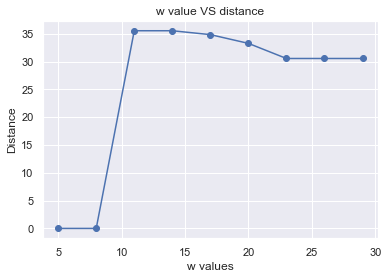

In [64]:
plt.plot(w_list, distance, "-")
plt.scatter(w_list, distance)
plt.xlabel('w values')
plt.ylabel('Distance')
plt.title('w value VS distance')

Text(0.5, 1.0, 'w value VS average wait time')

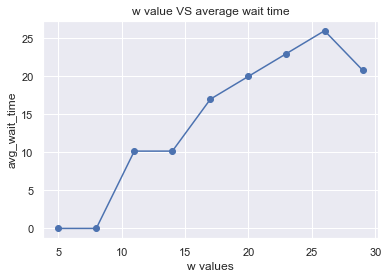

In [65]:
plt.plot(w_list, avg_wait_time, "-")
plt.scatter(w_list, avg_wait_time)
plt.xlabel('w values')
plt.ylabel('avg_wait_time')
plt.title('w value VS average wait time')

Text(0.5, 1.0, 'w value VS max wait time')

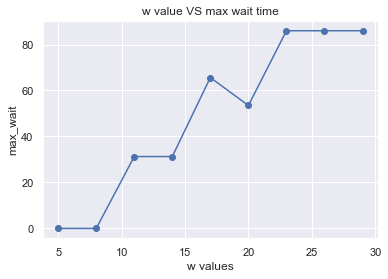

In [66]:
plt.plot(w_list, max_wait, "-")
plt.scatter(w_list, max_wait)
plt.xlabel('w values')
plt.ylabel('max_wait')
plt.title('w value VS max wait time')

sensitivity on max metrics

In [67]:
def model3_eval_max(wait_t):
    # Variable indicate if a route is picked
    xvar = pulp.LpVariable.dict("x", (start_spots, spots, steps, drivers), cat=pulp.LpBinary)

    # Variable indicate the total time used in minutes
    Dvar = pulp.LpVariable.dict("D", (steps,drivers), lowBound=0.0, cat=pulp.LpContinuous)

    # Variable indicate the average wait time for customers used in minutes at step t
    Wvar = pulp.LpVariable.dict("W", customers, lowBound=0.0, cat=pulp.LpContinuous)
    
    # Initialize model and objective sense
    RouteModel = pulp.LpProblem(name="RouteModel", sense=pulp.LpMinimize)
    
    
    # Visit every restaurant and customer once
    for j in spots:
        if j not in starts:
            RouteModel += pulp.lpSum([xvar[(i,j,t,s)] for i in start_spots if i != j for t in steps for s in drivers]) == 1
        else:
            RouteModel += pulp.lpSum([xvar[(i,j,t,s)] for i in start_spots if i != j for t in steps for s in drivers]) <= 1

    # For every driver, at step 0, if the start point of route is in start_region, only one route or no route is allowed
    # if the start point of route is not the start_region of the driver at step 0, no route allowed
    for s in drivers:
        RouteModel += pulp.lpSum([xvar[(starts[s],j,0,s)] for j in spots if j not in starts]) == 1 # change later
        RouteModel += pulp.lpSum([xvar[(i,j,0,s)] for i in spots if i != starts[s] for j in spots]) == 0
        if starts[s] not in spots:
            RouteModel += pulp.lpSum([xvar[(starts[s],j,t,s)] for j in spots for t in steps if t != 0]) == 0 

    # For each driver in each step, they can choose to move one step or not move
    for s in drivers:
        for t in steps:
            RouteModel += pulp.lpSum([xvar[(i,j,t,s)] for i in start_spots for j in spots]) <= 1


    # add step constraint if necessary
    for s in drivers:
        for t in steps[:-1]:
            RouteModel += pulp.lpSum([xvar[i,j,t,s] for i in start_spots for j in spots]) >= \
            pulp.lpSum([xvar[i,j,t+1,s] for i in start_spots for j in spots])

    # The corresponding restaurant must been visited before the customer
    for t in steps[:-1]:
        for j in customers:
            for s in drivers:
                RouteModel += pulp.lpSum([xvar[(restaurants[customers.index(j)],i,m,s)] for i in spots for m in list(range(t+1))])\
                >= pulp.lpSum([xvar[(i,j,t,s)] for i in start_spots if i != j])        

    # Conservation of flow
    # for restaurant, the outflow = inflow
    for j in restaurants:
        for t in steps[:-1]: 
            for s in drivers:
                RouteModel += pulp.lpSum([xvar[(i,j,t,s)] for i in start_spots if i != j]) ==  pulp.lpSum([xvar[(j,k,t+1,s)] for k in spots])

    # for customers, we allow outflow <= inflow so that driver can stop at customers 
    for j in customers:
        for t in steps[:-1]: 
            for s in drivers:
                RouteModel += pulp.lpSum([xvar[(i,j,t,s)] for i in start_spots if i != j]) >=  pulp.lpSum([xvar[(j,k,t+1,s)] for k in spots])    

    # cannot go from i to i
    for t in steps:
        for s in drivers:
            RouteModel += pulp.lpSum([xvar[(i,j,t,s)] for i in start_spots for j in spots if i == j]) == 0


    # D_t for time windows       

    for t in steps:
        for d in drivers:
            if t == 0:
                RouteModel += Dvar[0,d] >= pulp.lpSum(xvar[(start_region[d],j,t,d)] * order.loc[order['restaurant'] == j]['reference minutes'].values[0] for j in restaurants) 
            else:
                RouteModel += Dvar[t,d] >= Dvar[t-1,d] + pulp.lpSum(distances[(i,j)]/(velocity[d]/60) * xvar[(i,j,t,d)] for i in start_spots for j in spots if i != j) + \
                    5 * pulp.lpSum(xvar[(i,j,t,d)] for i in start_spots for j in customers)
            for j in restaurants:
                RouteModel += Dvar[t,d] >= pulp.lpSum(xvar[(i,j,t,d)] * order.loc[order['restaurant'] == j]['reference minutes'].values[0] for i in start_spots if i != j)

    #W_t for wait time   

    for j in customers:
        for t in steps:
            for d in drivers:
                RouteModel += Wvar[j] >= Dvar[t,d] - 5 - order.loc[order['customer'] == j]['reference minutes'].values[0] - 10000 * (1 - pulp.lpSum(xvar[(i, j, t, d)] for i in start_spots if i != j))
                RouteModel += Wvar[j] <= Dvar[t,d] - 5 - order.loc[order['customer'] == j]['reference minutes'].values[0] + 10000 * (1 - pulp.lpSum(xvar[(i, j, t, d)] for i in start_spots if i != j))
    for j in customers:
        RouteModel += Wvar[j]  <= wait_t
    
    # D_ij * X_ij 
    obj = pulp.lpSum(distances[(i,j)] * xvar[(i,j,t,d)] for i in start_spots for j in spots if j != i for t in steps for d in drivers)

    # add objective to model
    RouteModel += obj
    
    # Solve model
    RouteModel.solve()
    max_wait = 0
    total_wait = 0
    for s in drivers:
        for t in steps:
            for i in start_spots:
                for j in spots:
                    if xvar[(i, j, t, s)].varValue == 1:
                        temp = 0
                        if j in customers:
                            temp = pulp.value(Wvar[j])
                        max_wait = max(max_wait,temp)
                        total_wait += temp
    return pulp.LpStatus[RouteModel.status], pulp.value(RouteModel.objective),total_wait/len(customers),max_wait                      

In [68]:
w_list = []
distance = []
avg_wait_time = []
max_wait = []
for i in range(30,100,5):
    w_list.append(i)
    stat,value,wait,max_wait_time = model3_eval_max(i)
    if stat == 'Infeasible':
        distance.append(0)
        avg_wait_time.append(0)
        max_wait.append(0)
    else:
        distance.append(value)
        avg_wait_time.append(wait)
        max_wait.append(max_wait_time)
    print(i)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/lydia/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/e4a1558863254b39884fd893cdb6461a-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/e4a1558863254b39884fd893cdb6461a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 795 COLUMNS
At line 31734 RHS
At line 32525 BOUNDS
At line 34902 ENDATA
Problem MODEL has 790 rows, 2405 columns and 23921 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 26.9399 - 0.01 seconds
Cgl0002I 550 variables fixed
Cgl0003I 123 fixed, 0 tightened bounds, 270 strengthened rows, 0 substitutions
Cgl0003I 15 fixed, 0 tightened bounds, 205 strengthened rows, 0 substitutions
Cgl0003I 2 fixed, 0 tightened bounds, 193 strengthened rows, 0

Text(0.5, 1.0, 'w value VS distance(alternativ metric)')

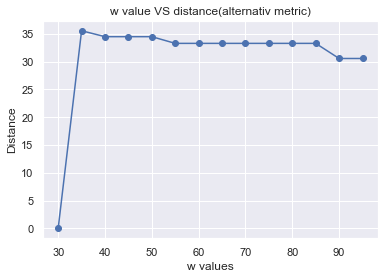

In [69]:
plt.plot(w_list, distance, "-")
plt.scatter(w_list, distance)
plt.xlabel('w values')
plt.ylabel('Distance')
plt.title('w value VS distance(alternativ metric)')

Text(0.5, 1.0, 'w value VS average wait time(alternativ metric)')

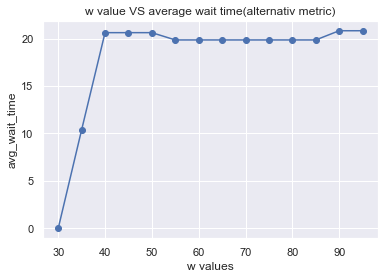

In [70]:
plt.plot(w_list, avg_wait_time, "-")
plt.scatter(w_list, avg_wait_time)
plt.xlabel('w values')
plt.ylabel('avg_wait_time')
plt.title('w value VS average wait time(alternativ metric)')

Text(0.5, 1.0, 'w value VS max wait time(alternativ metric)')

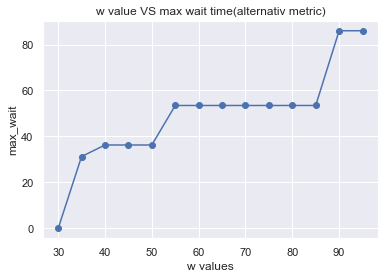

In [71]:
plt.plot(w_list, max_wait, "-")
plt.scatter(w_list, max_wait)
plt.xlabel('w values')
plt.ylabel('max_wait')
plt.title('w value VS max wait time(alternativ metric)')

# Part 4

## Join the restaurant and customer latitude and longitude with the order table

In [72]:
region = pd.read_csv("regions.csv")
region

,name,province,code,latitude,longitude
0,Scarborough (Malvern / Rouge River),Ontario,M1B,43.8113,-79.1930
1,Scarborough (Rouge Hill / Port Union / Highlan...,Ontario,M1C,43.7878,-79.1564
2,Scarborough (Guildwood / Morningside / Ellesmere),Ontario,M1E,43.7678,-79.1866
3,Scarborough (Woburn),Ontario,M1G,43.7712,-79.2144
4,Scarborough (Cedarbrae),Ontario,M1H,43.7686,-79.2389
...,...,...,...,...,...
97,Weston,Ontario,M9N,43.7068,-79.5170
98,Etobicoke (Westmount),Ontario,M9P,43.6949,-79.5323
99,Etobicoke (Kingsview Village / St. Phillips / ...,Ontario,M9R,43.6898,-79.5582
100,Etobicoke (South Steeles / Silverstone / Humbe...,Ontario,M9V,43.7432,-79.5876


## Comparison of performance with part 3

In [73]:
order = df_part3
order

,restaurant,customer,estimated availability,reference minutes
0,Downtown Toronto (Central Bay Street),North York (Armour Heights / Wilson Heights / ...,2022-04-02 17:17:00,0.0
1,Downtown Toronto (Christie),West Toronto (Brockton / Parkdale Village / Ex...,2022-04-02 17:49:00,32.0
2,Downtown Toronto (Ryerson),York (Fairbank / Oakwood),2022-04-02 18:17:00,60.0
3,Downtown Toronto (St. James Park),East Toronto (The Beaches),2022-04-02 17:53:00,36.0
4,Downtown Toronto (Kensington Market / Chinatow...,Downtown Toronto (Central Bay Street),2022-04-02 17:24:00,7.0


In [74]:
# Join the two tables based on "restaurant" in "order" and "name" in "region" 
merged_df = pd.merge(order, region, left_on='restaurant', right_on='name', how = "left")

merged_df.rename(columns={'latitude':'restaurant latitude', 'longitude':'restaurant longitude'}, inplace=True)

merged_df.drop(['name', 'province', 'code'], axis=1, inplace=True)

complete_order = pd.merge(merged_df, region, left_on='customer', right_on='name', how = "left")

complete_order.rename(columns={'latitude':'customer latitude', 'longitude':'customer longitude'}, inplace=True)

complete_order.drop(['name', 'province', 'code'], axis=1, inplace=True)

complete_order["average latitude"] = (complete_order["restaurant latitude"] + complete_order["customer latitude"])/2

complete_order["average longitude"] = (complete_order["restaurant longitude"] + complete_order["customer longitude"])/2

complete_order[['restaurant', 'customer', 'average latitude', 'average longitude']]

,restaurant,customer,average latitude,average longitude
0,Downtown Toronto (Central Bay Street),North York (Armour Heights / Wilson Heights / ...,43.70495,-79.41660
1,Downtown Toronto (Christie),West Toronto (Brockton / Parkdale Village / Ex...,43.65330,-79.42530
2,Downtown Toronto (Ryerson),York (Fairbank / Oakwood),43.67305,-79.41450
3,Downtown Toronto (St. James Park),East Toronto (The Beaches),43.66485,-79.33485
4,Downtown Toronto (Kensington Market / Chinatow...,Downtown Toronto (Central Bay Street),43.65525,-79.39190


In [75]:
driver = pd.read_csv("part3_drivers.csv")
driver

,start region,velocity
0,Downtown Toronto (Richmond / Adelaide / King),40
1,Downtown Toronto (St. James Park),35
2,Downtown Toronto (Church and Wellesley),32


In [76]:
# Join the two tables based on "start region" in "driver" and "name" in "region" 
complete_driver = pd.merge(driver, region, left_on='start region', right_on='name', how = "left")

complete_driver.rename(columns={'latitude':'driver latitude', 'longitude':'driver longitude'}, inplace=True)

complete_driver.drop(['name', 'province', 'code'], axis=1, inplace=True)

complete_driver

,start region,velocity,driver latitude,driver longitude
0,Downtown Toronto (Richmond / Adelaide / King),40,43.6496,-79.3833
1,Downtown Toronto (St. James Park),35,43.6513,-79.3756
2,Downtown Toronto (Church and Wellesley),32,43.6656,-79.3830


Perform K means clustering based on the longitute and latitude of restuarants and customers

In [77]:
from sklearn.cluster import KMeans

In [78]:
complete_driver[['driver latitude', 'driver longitude']]

,driver latitude,driver longitude
0,43.6496,-79.3833
1,43.6513,-79.3756
2,43.6656,-79.3830


In [79]:
# Set k to the number of available drivers
k = len(complete_driver)

# Create a KMeans object with the initial centroids set to the drivers' locations
kmeans = KMeans(n_clusters=k, init=complete_driver[['driver latitude', 'driver longitude']].values)

# Fit the KMeans object on the order data
kmeans.fit(complete_order[['average latitude', 'average longitude']])

# Add the cluster information to the complete_order DataFrame
complete_order['cluster'] = kmeans.labels_

complete_order

/Users/lydia/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


,restaurant,customer,estimated availability,reference minutes,restaurant latitude,restaurant longitude,customer latitude,customer longitude,average latitude,average longitude,cluster
0,Downtown Toronto (Central Bay Street),North York (Armour Heights / Wilson Heights / ...,2022-04-02 17:17:00,0.0,43.6564,-79.3860,43.7535,-79.4472,43.70495,-79.41660,2
1,Downtown Toronto (Christie),West Toronto (Brockton / Parkdale Village / Ex...,2022-04-02 17:49:00,32.0,43.6683,-79.4205,43.6383,-79.4301,43.65330,-79.42530,0
2,Downtown Toronto (Ryerson),York (Fairbank / Oakwood),2022-04-02 18:17:00,60.0,43.6572,-79.3783,43.6889,-79.4507,43.67305,-79.41450,2
3,Downtown Toronto (St. James Park),East Toronto (The Beaches),2022-04-02 17:53:00,36.0,43.6513,-79.3756,43.6784,-79.2941,43.66485,-79.33485,1
4,Downtown Toronto (Kensington Market / Chinatow...,Downtown Toronto (Central Bay Street),2022-04-02 17:24:00,7.0,43.6541,-79.3978,43.6564,-79.3860,43.65525,-79.39190,0


In [80]:
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

# Assign each driver to a unique cluster
driver_cluster_assignments = []
available_clusters = set(range(k))
for driver_location in complete_driver[['driver latitude', 'driver longitude']].values:
    distances = [euclidean_distance(driver_location, centroid) for centroid in kmeans.cluster_centers_]
    sorted_cluster_indices = np.argsort(distances)
    
    for index in sorted_cluster_indices:
        if index in available_clusters:
            driver_cluster_assignments.append(index)
            available_clusters.remove(index)
            break

# Add the cluster assignments to the complete_driver DataFrame
complete_driver['cluster'] = driver_cluster_assignments

complete_driver

,start region,velocity,driver latitude,driver longitude,cluster
0,Downtown Toronto (Richmond / Adelaide / King),40,43.6496,-79.3833,0
1,Downtown Toronto (St. James Park),35,43.6513,-79.3756,1
2,Downtown Toronto (Church and Wellesley),32,43.6656,-79.3830,2


In [81]:
drivers = complete_driver.index.to_list()
driver_df = {}

for driver in drivers:
    driver_df[(driver, complete_driver.iloc[driver, 0], complete_driver.iloc[driver, 1])] = complete_order[complete_order['cluster'] == driver]



In [82]:
def q2(start, velocity, order):
    earliest_time = order['estimated availability'].min()
    order['reference minutes'] = (order['estimated availability'] - earliest_time).dt.total_seconds() // 60
    origins = list(df_distances['origin'].unique())
    numorigins = len(origins)
    destinations = list(df_distances['destination'].unique())
    numdestinations = len(destinations)
    restaurants = list(order['restaurant'])
    customers = list(order['customer'])
    origin_point = start
    combined = pd.concat([order['restaurant'], order['customer']])
    spots = list(combined.unique())
    if origin_point not in customers:
        spots.append(origin_point)
        steps  = list(range(len(spots)-1)) 
    if origin_point in customers:
        steps  = list(range(len(spots)))
    W = 120
    distances = {}
    for i in origins:
        for j in destinations:
            if i != j:
                distances[(i,j)] = df_distances.loc[(df_distances['origin'] == i) & (df_distances['destination'] == j)]['distance'].values[0]
    distances_time = {}
    for i in origins:
        for j in destinations:
            if i != j:
                distances_time[(i,j)] = df_distances.loc[(df_distances['origin'] == i) & (df_distances['destination'] == j)]['distance'].values[0]/velocity*60
    xvar = pulp.LpVariable.dict("x", (spots, spots, steps), cat=pulp.LpBinary)
    Dvar = pulp.LpVariable.dict("D", steps, lowBound=0.0, cat=pulp.LpContinuous)
    Wvar = pulp.LpVariable.dict("W", customers, lowBound=0.0, cat=pulp.LpContinuous)
    RouteModel = pulp.LpProblem(name="RouteModel", sense=pulp.LpMinimize)
    for j in spots:
        if j != origin_point:
            RouteModel += pulp.lpSum([xvar[(i,j,t)] for i in spots for t in steps]) == 1
        else:
            if j in customers:
                RouteModel += pulp.lpSum([xvar[(i,j,t)] for i in spots for t in steps]) == 1
    for j in spots:
        for t in steps[:-1]: 
            RouteModel += pulp.lpSum([xvar[(i,j,t)] for i in spots if i != j]) ==  pulp.lpSum([xvar[(j,k,t+1)] for k in spots])
        
    for i in spots:
        if i == origin_point:
            RouteModel += pulp.lpSum([xvar[(i,j,0)] for j in spots]) == 1      
        else:
            RouteModel += pulp.lpSum([xvar[(i,j,0)] for j in spots]) == 0
    for t in steps:
        for j in customers:
            RouteModel += pulp.lpSum([xvar[(restaurants[customers.index(j)], k, m)] for k in spots for m in list(range(t+1))])\
            >= pulp.lpSum([xvar[(i,j,t)] for i in spots])
    RouteModel += pulp.lpSum([xvar[(i,j,max(steps))] for i in spots for j in customers]) == 1              
    for t in steps:
        if t == 0:
            RouteModel += Dvar[0] >= pulp.lpSum(xvar[(origin_point,j,t)] * order.loc[order['restaurant'] == j]['reference minutes'].values[0] for j in restaurants) 
        else:
            RouteModel += Dvar[t] >= Dvar[t-1] + pulp.lpSum(distances_time[(i,j)] * xvar[(i,j,t)] for i in spots for j in spots if i != j) + \
                5 * pulp.lpSum(xvar[(i,j,t)] for i in spots for j in customers)
        for j in restaurants:
            RouteModel += Dvar[t] >= pulp.lpSum(xvar[(i,j,t)] * order.loc[order['restaurant'] == j]['reference minutes'].values[0] for i in spots if i != j)
    for j in customers:
        for t in steps:
            RouteModel += Wvar[j] >= Dvar[t] - 5 - order.loc[order['customer'] == j]['reference minutes'].values[0] - 10000 * (1 - pulp.lpSum(xvar[(i, j, t)] for i in spots if i != j))
            RouteModel += Wvar[j] <= Dvar[t] - 5 - order.loc[order['customer'] == j]['reference minutes'].values[0] + 10000 * (1 - pulp.lpSum(xvar[(i, j, t)] for i in spots if i != j))
    RouteModel += pulp.lpSum(Wvar[j] for j in customers) / len(customers) <= W
    obj = pulp.lpSum(distances[(i,j)] * xvar[(i,j,t)] for i in spots for j in spots if j != i for t in steps)
    RouteModel += obj
    RouteModel.solve()
    route = []
    n = 0
    total_wait = 0
    waiting_time_sum = sum(pulp.value(Wvar[c]) for c in customers)
    average_waiting_time = waiting_time_sum / len(customers)
    obj = pulp.value(RouteModel.objective)
    return ((obj, average_waiting_time, len(order)))

In [83]:
results = []
for key,value in driver_df.items():
    results.append(q2(key[1], key[2], value))
results

/var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/ipykernel_72207/3963624159.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order['reference minutes'] = (order['estimated availability'] - earliest_time).dt.total_seconds() // 60


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/lydia/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/30b55e000fdf411cb82d4661aa873e9a-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/30b55e000fdf411cb82d4661aa873e9a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 67 COLUMNS
At line 926 RHS
At line 989 BOUNDS
At line 1090 ENDATA
Problem MODEL has 62 rows, 106 columns and 570 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 6.93273 - 0.00 seconds
Cgl0002I 20 variables fixed
Cgl0003I 17 fixed, 0 tightened bounds, 14 strengthened rows, 0 substitutions
Cgl0003I 16 fixed, 0 tightened bounds, 0 strengthened rows, 2 substitutions
Cgl0003I 6 fixed, 0 tightened bounds, 1 strengthened rows, 3 substitutions
Cg

/var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/ipykernel_72207/3963624159.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order['reference minutes'] = (order['estimated availability'] - earliest_time).dt.total_seconds() // 60


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/lydia/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/cc7372a88b174aefaca778de3abe5a1a-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/cc7372a88b174aefaca778de3abe5a1a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 24 COLUMNS
At line 95 RHS
At line 115 BOUNDS
At line 124 ENDATA
Problem MODEL has 19 rows, 11 columns and 50 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.01



/var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/ipykernel_72207/3963624159.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order['reference minutes'] = (order['estimated availability'] - earliest_time).dt.total_seconds() // 60


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/lydia/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/d7dccb4c6d7849749ab3053d19295d97-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/d7dccb4c6d7849749ab3053d19295d97-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 67 COLUMNS
At line 926 RHS
At line 989 BOUNDS
At line 1090 ENDATA
Problem MODEL has 62 rows, 106 columns and 570 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 10.7337 - 0.00 seconds
Cgl0002I 20 variables fixed
Cgl0003I 20 fixed, 0 tightened bounds, 15 strengthened rows, 0 substitutions
Cgl0003I 18 fixed, 0 tightened bounds, 3 strengthened rows, 5 substitutions
Cgl0003I 5 fixed, 0 tightened bounds, 0 strengthened rows, 7 substitutions
Cg

[(8.75116131301983, 3.30544255, 2),
 (14.430124888276898, 0.0, 1),
 (15.157594055213657, 52.2917205, 2)]

In [84]:
tot_distance = sum([i[0] for i in results])
tot_distance

38.338880256510386

In [85]:
avg_wait = sum([i[1]*i[2] for i in results])/len(complete_order)
avg_wait

22.23886522

In [86]:
order = pd.read_csv('part4_large.csv', parse_dates=['estimated availability'])
order

,restaurant,customer,estimated availability
0,Downtown Toronto (Central Bay Street),North York (Armour Heights / Wilson Heights / ...,2022-04-02 17:17:00
1,Downtown Toronto (Christie),West Toronto (Brockton / Parkdale Village / Ex...,2022-04-02 17:49:00
2,Downtown Toronto (Ryerson),York (Fairbank / Oakwood),2022-04-02 18:17:00
3,Downtown Toronto (St. James Park),East Toronto (The Beaches),2022-04-02 17:53:00
4,Downtown Toronto (Kensington Market / Chinatow...,Downtown Toronto (Central Bay Street),2022-04-02 17:24:00
5,Downtown Toronto (Rosedale),Downtown Toronto (CN Tower / King and Spadina ...,2022-04-02 19:35:00
6,Downtown Toronto (Regent Park / Port of Toronto),Downtown Toronto (Toronto Dominion Centre / De...,2022-04-02 18:21:00
7,Downtown Toronto (St. James Town / Cabbagetown),York (Runnymede / The Junction North),2022-04-02 17:10:00
8,Downtown Toronto (Underground city),Central Toronto (Summerhill West / Rathnelly /...,2022-04-02 17:21:00
9,Downtown Toronto (Church and Wellesley),East Toronto (The Danforth West / Riverdale),2022-04-02 19:21:00


In [87]:
# Join the two tables based on "restaurant" in "order" and "name" in "region" 
merged_df = pd.merge(order, region, left_on='restaurant', right_on='name', how = "left")

merged_df.rename(columns={'latitude':'restaurant latitude', 'longitude':'restaurant longitude'}, inplace=True)

merged_df.drop(['name', 'province', 'code'], axis=1, inplace=True)

complete_order = pd.merge(merged_df, region, left_on='customer', right_on='name', how = "left")

complete_order.rename(columns={'latitude':'customer latitude', 'longitude':'customer longitude'}, inplace=True)

complete_order.drop(['name', 'province', 'code'], axis=1, inplace=True)

complete_order["average latitude"] = (complete_order["restaurant latitude"] + complete_order["customer latitude"])/2

complete_order["average longitude"] = (complete_order["restaurant longitude"] + complete_order["customer longitude"])/2

complete_order[['restaurant', 'customer', 'average latitude', 'average longitude']]

,restaurant,customer,average latitude,average longitude
0,Downtown Toronto (Central Bay Street),North York (Armour Heights / Wilson Heights / ...,43.70495,-79.41660
1,Downtown Toronto (Christie),West Toronto (Brockton / Parkdale Village / Ex...,43.65330,-79.42530
2,Downtown Toronto (Ryerson),York (Fairbank / Oakwood),43.67305,-79.41450
3,Downtown Toronto (St. James Park),East Toronto (The Beaches),43.66485,-79.33485
4,Downtown Toronto (Kensington Market / Chinatow...,Downtown Toronto (Central Bay Street),43.65525,-79.39190
5,Downtown Toronto (Rosedale),Downtown Toronto (CN Tower / King and Spadina ...,43.66155,-79.38625
6,Downtown Toronto (Regent Park / Port of Toronto),Downtown Toronto (Toronto Dominion Centre / De...,43.65120,-79.37245
7,Downtown Toronto (St. James Town / Cabbagetown),York (Runnymede / The Junction North),43.67160,-79.42640
8,Downtown Toronto (Underground city),Central Toronto (Summerhill West / Rathnelly /...,43.66765,-79.39240
9,Downtown Toronto (Church and Wellesley),East Toronto (The Danforth West / Riverdale),43.67295,-79.36840


In [88]:
driver = pd.read_csv("part4_drivers.csv")
driver

,start region,velocity
0,Downtown Toronto (Richmond / Adelaide / King),20
1,Downtown Toronto (St. James Park),20
2,Downtown Toronto (Church and Wellesley),20
3,Downtown Toronto (Christie),20
4,Downtown Toronto (Church and Wellesley),20
5,Downtown Toronto Stn A PO Boxes 25 The Esplana...,20
6,Downtown Toronto (CN Tower / King and Spadina ...,20
7,Downtown Toronto (Rosedale),20
8,Downtown Toronto (University of Toronto / Harb...,20
9,Downtown Toronto (Ryerson),20


In [89]:
# Join the two tables based on "start region" in "driver" and "name" in "region" 
complete_driver = pd.merge(driver, region, left_on='start region', right_on='name', how = "left")

complete_driver.rename(columns={'latitude':'driver latitude', 'longitude':'driver longitude'}, inplace=True)

complete_driver.drop(['name', 'province', 'code'], axis=1, inplace=True)

complete_driver

,start region,velocity,driver latitude,driver longitude
0,Downtown Toronto (Richmond / Adelaide / King),20,43.6496,-79.3833
1,Downtown Toronto (St. James Park),20,43.6513,-79.3756
2,Downtown Toronto (Church and Wellesley),20,43.6656,-79.3830
3,Downtown Toronto (Christie),20,43.6683,-79.4205
4,Downtown Toronto (Church and Wellesley),20,43.6656,-79.3830
5,Downtown Toronto Stn A PO Boxes 25 The Esplana...,20,43.6437,-79.3787
6,Downtown Toronto (CN Tower / King and Spadina ...,20,43.6404,-79.3995
7,Downtown Toronto (Rosedale),20,43.6827,-79.3730
8,Downtown Toronto (University of Toronto / Harb...,20,43.6629,-79.3987
9,Downtown Toronto (Ryerson),20,43.6572,-79.3783


# Perform K means clustering based on the longitute and latitude of restuarants and customers

In [90]:
from sklearn.cluster import KMeans

In [91]:
complete_driver[['driver latitude', 'driver longitude']]

,driver latitude,driver longitude
0,43.6496,-79.3833
1,43.6513,-79.3756
2,43.6656,-79.3830
3,43.6683,-79.4205
4,43.6656,-79.3830
5,43.6437,-79.3787
6,43.6404,-79.3995
7,43.6827,-79.3730
8,43.6629,-79.3987
9,43.6572,-79.3783


In [92]:
# Set k to the number of available drivers
k = len(complete_driver)

# Create a KMeans object with the initial centroids set to the drivers' locations
kmeans = KMeans(n_clusters=k, init=complete_driver[['driver latitude', 'driver longitude']].values)

# Fit the KMeans object on the order data
kmeans.fit(complete_order[['average latitude', 'average longitude']])

# Add the cluster information to the complete_order DataFrame
complete_order['cluster'] = kmeans.labels_

complete_order

/Users/lydia/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


,restaurant,customer,estimated availability,restaurant latitude,restaurant longitude,customer latitude,customer longitude,average latitude,average longitude,cluster
0,Downtown Toronto (Central Bay Street),North York (Armour Heights / Wilson Heights / ...,2022-04-02 17:17:00,43.6564,-79.3860,43.7535,-79.4472,43.70495,-79.41660,0
1,Downtown Toronto (Christie),West Toronto (Brockton / Parkdale Village / Ex...,2022-04-02 17:49:00,43.6683,-79.4205,43.6383,-79.4301,43.65330,-79.42530,3
2,Downtown Toronto (Ryerson),York (Fairbank / Oakwood),2022-04-02 18:17:00,43.6572,-79.3783,43.6889,-79.4507,43.67305,-79.41450,3
3,Downtown Toronto (St. James Park),East Toronto (The Beaches),2022-04-02 17:53:00,43.6513,-79.3756,43.6784,-79.2941,43.66485,-79.33485,4
4,Downtown Toronto (Kensington Market / Chinatow...,Downtown Toronto (Central Bay Street),2022-04-02 17:24:00,43.6541,-79.3978,43.6564,-79.3860,43.65525,-79.39190,8
5,Downtown Toronto (Rosedale),Downtown Toronto (CN Tower / King and Spadina ...,2022-04-02 19:35:00,43.6827,-79.3730,43.6404,-79.3995,43.66155,-79.38625,8
6,Downtown Toronto (Regent Park / Port of Toronto),Downtown Toronto (Toronto Dominion Centre / De...,2022-04-02 18:21:00,43.6555,-79.3626,43.6469,-79.3823,43.65120,-79.37245,1
7,Downtown Toronto (St. James Town / Cabbagetown),York (Runnymede / The Junction North),2022-04-02 17:10:00,43.6684,-79.3689,43.6748,-79.4839,43.67160,-79.42640,3
8,Downtown Toronto (Underground city),Central Toronto (Summerhill West / Rathnelly /...,2022-04-02 17:21:00,43.6492,-79.3823,43.6861,-79.4025,43.66765,-79.39240,8
9,Downtown Toronto (Church and Wellesley),East Toronto (The Danforth West / Riverdale),2022-04-02 19:21:00,43.6656,-79.3830,43.6803,-79.3538,43.67295,-79.36840,7


In [93]:
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

# Assign each driver to a unique cluster
driver_cluster_assignments = []
available_clusters = set(range(k))
for driver_location in complete_driver[['driver latitude', 'driver longitude']].values:
    distances = [euclidean_distance(driver_location, centroid) for centroid in kmeans.cluster_centers_]
    sorted_cluster_indices = np.argsort(distances)
    
    for index in sorted_cluster_indices:
        if index in available_clusters:
            driver_cluster_assignments.append(index)
            available_clusters.remove(index)
            break

# Add the cluster assignments to the complete_driver DataFrame
complete_driver['cluster'] = driver_cluster_assignments

complete_driver

,start region,velocity,driver latitude,driver longitude,cluster
0,Downtown Toronto (Richmond / Adelaide / King),20,43.6496,-79.3833,1
1,Downtown Toronto (St. James Park),20,43.6513,-79.3756,8
2,Downtown Toronto (Church and Wellesley),20,43.6656,-79.3830,2
3,Downtown Toronto (Christie),20,43.6683,-79.4205,3
4,Downtown Toronto (Church and Wellesley),20,43.6656,-79.3830,7
5,Downtown Toronto Stn A PO Boxes 25 The Esplana...,20,43.6437,-79.3787,6
6,Downtown Toronto (CN Tower / King and Spadina ...,20,43.6404,-79.3995,9
7,Downtown Toronto (Rosedale),20,43.6827,-79.3730,4
8,Downtown Toronto (University of Toronto / Harb...,20,43.6629,-79.3987,0
9,Downtown Toronto (Ryerson),20,43.6572,-79.3783,5


In [94]:
drivers = complete_driver.index.to_list()
driver_df = {}

for driver in drivers:
    driver_df[(driver, complete_driver.iloc[driver, 0], complete_driver.iloc[driver, 1])] = complete_order[complete_order['cluster'] == driver]



In [95]:
def q2(start, velocity, order):
    earliest_time = order['estimated availability'].min()
    order['reference minutes'] = (order['estimated availability'] - earliest_time).dt.total_seconds() // 60
    origins = list(df_distances['origin'].unique())
    numorigins = len(origins)
    destinations = list(df_distances['destination'].unique())
    numdestinations = len(destinations)
    restaurants = list(order['restaurant'])
    customers = list(order['customer'])
    origin_point = start
    combined = pd.concat([order['restaurant'], order['customer']])
    spots = list(combined.unique())
    if origin_point not in customers:
        spots.append(origin_point)
        steps  = list(range(len(spots)-1)) 
    if origin_point in customers:
        steps  = list(range(len(spots)))
    W = 120
    distances = {}
    for i in origins:
        for j in destinations:
            if i != j:
                distances[(i,j)] = df_distances.loc[(df_distances['origin'] == i) & (df_distances['destination'] == j)]['distance'].values[0]
    distances_time = {}
    for i in origins:
        for j in destinations:
            if i != j:
                distances_time[(i,j)] = df_distances.loc[(df_distances['origin'] == i) & (df_distances['destination'] == j)]['distance'].values[0]/velocity*60
    xvar = pulp.LpVariable.dict("x", (spots, spots, steps), cat=pulp.LpBinary)
    Dvar = pulp.LpVariable.dict("D", steps, lowBound=0.0, cat=pulp.LpContinuous)
    Wvar = pulp.LpVariable.dict("W", customers, lowBound=0.0, cat=pulp.LpContinuous)
    RouteModel = pulp.LpProblem(name="RouteModel", sense=pulp.LpMinimize)
    for j in spots:
        if j != origin_point:
            RouteModel += pulp.lpSum([xvar[(i,j,t)] for i in spots for t in steps]) == 1
        else:
            if j in customers:
                RouteModel += pulp.lpSum([xvar[(i,j,t)] for i in spots for t in steps]) == 1
    for j in spots:
        for t in steps[:-1]: 
            RouteModel += pulp.lpSum([xvar[(i,j,t)] for i in spots if i != j]) ==  pulp.lpSum([xvar[(j,k,t+1)] for k in spots])
        
    for i in spots:
        if i == origin_point:
            RouteModel += pulp.lpSum([xvar[(i,j,0)] for j in spots]) == 1      
        else:
            RouteModel += pulp.lpSum([xvar[(i,j,0)] for j in spots]) == 0
    for t in steps:
        for j in customers:
            RouteModel += pulp.lpSum([xvar[(restaurants[customers.index(j)], k, m)] for k in spots for m in list(range(t+1))])\
            >= pulp.lpSum([xvar[(i,j,t)] for i in spots])
    RouteModel += pulp.lpSum([xvar[(i,j,max(steps))] for i in spots for j in customers]) == 1              
    for t in steps:
        if t == 0:
            RouteModel += Dvar[0] >= pulp.lpSum(xvar[(origin_point,j,t)] * order.loc[order['restaurant'] == j]['reference minutes'].values[0] for j in restaurants) 
        else:
            RouteModel += Dvar[t] >= Dvar[t-1] + pulp.lpSum(distances_time[(i,j)] * xvar[(i,j,t)] for i in spots for j in spots if i != j) + \
                5 * pulp.lpSum(xvar[(i,j,t)] for i in spots for j in customers)
        for j in restaurants:
            RouteModel += Dvar[t] >= pulp.lpSum(xvar[(i,j,t)] * order.loc[order['restaurant'] == j]['reference minutes'].values[0] for i in spots if i != j)
    for j in customers:
        for t in steps:
            RouteModel += Wvar[j] >= Dvar[t] - 5 - order.loc[order['customer'] == j]['reference minutes'].values[0] - 10000 * (1 - pulp.lpSum(xvar[(i, j, t)] for i in spots if i != j))
            RouteModel += Wvar[j] <= Dvar[t] - 5 - order.loc[order['customer'] == j]['reference minutes'].values[0] + 10000 * (1 - pulp.lpSum(xvar[(i, j, t)] for i in spots if i != j))
    RouteModel += pulp.lpSum(Wvar[j] for j in customers) / len(customers) <= W
    obj = pulp.lpSum(distances[(i,j)] * xvar[(i,j,t)] for i in spots for j in spots if j != i for t in steps)
    RouteModel += obj
    RouteModel.solve()
    route = []
    n = 0
    total_wait = 0
    waiting_time_sum = sum(pulp.value(Wvar[c]) for c in customers)
    average_waiting_time = waiting_time_sum / len(customers)
    obj = pulp.value(RouteModel.objective)
    return ((obj, average_waiting_time, len(order)))

In [96]:
results = []
for key,value in driver_df.items():
    results.append(q2(key[1], key[2], value))
results

/var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/ipykernel_72207/3963624159.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order['reference minutes'] = (order['estimated availability'] - earliest_time).dt.total_seconds() // 60


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/lydia/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/5d4135e5f9764c55bf4fb23f78aaf2f1-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/5d4135e5f9764c55bf4fb23f78aaf2f1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 25 COLUMNS
At line 155 RHS
At line 176 BOUNDS
At line 195 ENDATA
Problem MODEL has 20 rows, 21 columns and 79 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 12.6517 - 0.00 seconds
Cgl0002I 6 variables fixed
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 12.6517 to -1.79769e+308
Probing was tried 0 times an

/var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/ipykernel_72207/3963624159.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order['reference minutes'] = (order['estimated availability'] - earliest_time).dt.total_seconds() // 60


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/lydia/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/9b11d0f1327f4e7386986db1a3c9ebd1-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/9b11d0f1327f4e7386986db1a3c9ebd1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 25 COLUMNS
At line 155 RHS
At line 176 BOUNDS
At line 195 ENDATA
Problem MODEL has 20 rows, 21 columns and 79 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2.99653 - 0.00 seconds
Cgl0002I 6 variables fixed
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 2.99653 to -1.79769e+308
Probing was tried 0 times an

/var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/ipykernel_72207/3963624159.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order['reference minutes'] = (order['estimated availability'] - earliest_time).dt.total_seconds() // 60


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/lydia/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/6cf45d8bc2e74c2cacb58c5feaabf341-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/6cf45d8bc2e74c2cacb58c5feaabf341-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 25 COLUMNS
At line 155 RHS
At line 176 BOUNDS
At line 195 ENDATA
Problem MODEL has 20 rows, 21 columns and 79 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 5.17026 - 0.00 seconds
Cgl0002I 6 variables fixed
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 5.17026 to -1.79769e+308
Probing was tried 0 times an

/var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/ipykernel_72207/3963624159.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order['reference minutes'] = (order['estimated availability'] - earliest_time).dt.total_seconds() // 60


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/lydia/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/7332ff76d4134d05aa2018f885d964a3-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/7332ff76d4134d05aa2018f885d964a3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 132 COLUMNS
At line 2349 RHS
At line 2477 BOUNDS
At line 2694 ENDATA
Problem MODEL has 127 rows, 225 columns and 1592 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 15.1775 - 0.00 seconds
Cgl0000I Cut generators found to be infeasible! (or unbounded)
Pre-processing says infeasible or unbounded
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.01   (Wallclock seconds):       0.02



/var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/ipykernel_72207/3963624159.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order['reference minutes'] = (order['estimated availability'] - earliest_time).dt.total_seconds() // 60


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/lydia/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/edb352f2d1a34d488f958ba0bd968088-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/edb352f2d1a34d488f958ba0bd968088-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 25 COLUMNS
At line 155 RHS
At line 176 BOUNDS
At line 195 ENDATA
Problem MODEL has 20 rows, 21 columns and 79 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 8.91293 - 0.00 seconds
Cgl0002I 6 variables fixed
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 8.91293 to -1.79769e+308
Probing was tried 0 times an

/var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/ipykernel_72207/3963624159.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order['reference minutes'] = (order['estimated availability'] - earliest_time).dt.total_seconds() // 60


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/lydia/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/5b354cfecf3c4816986ef8269ea8c857-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/5b354cfecf3c4816986ef8269ea8c857-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 25 COLUMNS
At line 155 RHS
At line 176 BOUNDS
At line 195 ENDATA
Problem MODEL has 20 rows, 21 columns and 79 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 19.3155 - 0.00 seconds
Cgl0002I 6 variables fixed
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 19.3155 to -1.79769e+308
Probing was tried 0 times an

/var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/ipykernel_72207/3963624159.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order['reference minutes'] = (order['estimated availability'] - earliest_time).dt.total_seconds() // 60


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/lydia/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/035ba366f88d4ae9a0b68587bb8aea17-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/035ba366f88d4ae9a0b68587bb8aea17-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 25 COLUMNS
At line 155 RHS
At line 176 BOUNDS
At line 195 ENDATA
Problem MODEL has 20 rows, 21 columns and 79 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 7.50573 - 0.00 seconds
Cgl0002I 6 variables fixed
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 7.50573 to -1.79769e+308
Probing was tried 0 times an

/var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/ipykernel_72207/3963624159.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order['reference minutes'] = (order['estimated availability'] - earliest_time).dt.total_seconds() // 60


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/lydia/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/aa11182748734ec48ad032e14f608c7f-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/aa11182748734ec48ad032e14f608c7f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 25 COLUMNS
At line 155 RHS
At line 176 BOUNDS
At line 195 ENDATA
Problem MODEL has 20 rows, 21 columns and 79 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 4.92583 - 0.00 seconds
Cgl0002I 6 variables fixed
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 4.92583 to -1.79769e+308
Probing was tried 0 times an

/var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/ipykernel_72207/3963624159.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order['reference minutes'] = (order['estimated availability'] - earliest_time).dt.total_seconds() // 60


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/lydia/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/aecdf151573c4ff8842d972f6aa160aa-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/aecdf151573c4ff8842d972f6aa160aa-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 223 COLUMNS
At line 6830 RHS
At line 7049 BOUNDS
At line 7698 ENDATA
Problem MODEL has 218 rows, 660 columns and 4702 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 10.1654 - 0.00 seconds
Cgl0002I 72 variables fixed
Cgl0003I 51 fixed, 0 tightened bounds, 34 strengthened rows, 0 substitutions
Cgl0003I 1 fixed, 0 tightened bounds, 30 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 27 strengthened rows, 0 substituti

/var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/ipykernel_72207/3963624159.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order['reference minutes'] = (order['estimated availability'] - earliest_time).dt.total_seconds() // 60


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/lydia/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/db00d234c43f4c97a918869bae82ca94-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/7s/6gbhl319599cbgp7ypgr60m00000gn/T/db00d234c43f4c97a918869bae82ca94-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 25 COLUMNS
At line 155 RHS
At line 176 BOUNDS
At line 195 ENDATA
Problem MODEL has 20 rows, 21 columns and 79 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 9.60021 - 0.00 seconds
Cgl0002I 6 variables fixed
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 9.60021 to -1.79769e+308
Probing was tried 0 times an

[(12.65167752577638, 120.0, 1),
 (2.996534586189478, 120.0, 1),
 (5.170262598754039, 120.0, 1),
 (15.17746436877123, 0.0, 3),
 (8.91293415432978, 120.0, 1),
 (19.315508846024933, 120.0, 1),
 (7.50573344955896, 120.0, 1),
 (4.925833438464758, 120.0, 1),
 (14.403764470382075, 73.009682825, 4),
 (9.600213234407047, 120.0, 1)]

In [97]:
tot_distance = sum([i[0] for i in results])
tot_distance

100.65992667265868

In [98]:
avg_wait = sum([i[1]*i[2] for i in results])/len(complete_order)
avg_wait

83.46924875333335